In [2]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc
import pickle
from tqdm import tqdm

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg
import os

save = 'figures/paper_plots/falloff/'

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [3]:
def report_max_ratios(times=[0, 100, 160, 300], var='c'):
    '''
    Report the max values and ratio of maxes for a variable in the time frames given
    Times should always be a list of 4 integers giving two time intervals to measure maxes from
    Returns:
        ratio of second max to first max (e.g. if second max is 50% of first, return 0.5)
        list of max values reported
        list of index location of max values (for plotting)
    '''
    indices = [np.argmax(cfg.t > t) for t in times]
    if indices[-1] == 0:
        indices[-1] = -1
    y = getattr(cfg, var)
    
    maxes = []
    pos = []
    for i in range(2):
        low = indices[i*2]
        high = indices[i*2 + 1]
        
        ymax = np.max(y[low:high])
        maxpos = np.argmax(y[low:high])
        
        pos.append(maxpos + low)
        maxes.append(ymax)
        
    ratio = maxes[1] / maxes[0]
    return ratio, maxes, pos

def slope_at_index(idx, var='c'):
    y = getattr(cfg, var)
    t2 = cfg.t[idx + 1]
    t1 = cfg.t[idx - 1]
    y2 = y[idx + 1]
    y1 = y[idx - 1]
    return (y2 - y1) / (t2 - t1)


def conditional_double_bath(glut=0.4, first=240, rest=310, mod=0, noise=False,
                           force_run=False):
    '''
    get experimental double bath c ratio from globals()['df'] if it is loaded
    otherwise run and save
    '''
    if 'df' in globals()['df']:
        df = globals()['df']
    else:
        df = pd.read_pickle('data/experiments/double_bath/dataframe')
        globals()['df'] = df
    
    df = df[df['glut'] == glut]
    df = df[df['first'] == first]
    df = df[df['rest'] == rest]
    df = df[df['mod'] == mod]
    df = df[df['noise'] == noise]
    
    kd1 = 0.02
    kd2 = 0.6
    
    #if no such experiment found, run it and save the results
    if len(df) == 0 or force_run:
        set_init()
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_vals = [0, glut, 0, glut, 0]
        cfg.kd1 = kd1 * mod
        cfg.kd2 = kd2 * mod
        sol = run_experiment('custom', t_f=80+first+rest, max_step=0.1)
        ratio, _, _ = report_max_ratios(times=ratio_times)
        
        df_row = pd.DataFrame([{
            'glut': glut,
            'first': first,
            'rest': rest,
            'mod': mod,
            'noise': noise,
            'ratio': ratio
        }], columns=['glut','first','rest','mod','noise','ratio'])
        df = pd.read_pickle('data/experiments/double_bath/dataframe')
        df = df.append(df_row, ignore_index=True)
        df.to_pickle('data/experiments/double_bath/dataframe')
        globals()['df'] = df
        return ratio
    else:
        ratio = df.iloc[0]['ratio']
        return ratio
    
    
def capture_c(t):
    '''
    get c at values of t
    '''
    idx = np.argmax(cfg.t >= t)
    c = cfg.c[idx]
    return c


import matplotlib.image as mpimg

falloff1 = np.array([    
    [0, 65, 66, 67, 68, 72, 75, 80, 87, 95, 100, 105, 107, 110, 120, 130, 140, 150, 160, 165, 170, 190, 230, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.94, 0.95, 0.7, 0.55, 0.4, 0.35, 0.37, 0.35, 0.3, 0.33, 0.3, 0.25, 0.2, 0.12, 0.1, 0.09, 0.08, 0.06, 0.055]
])
falloff2 = np.array([
    [0, 65, 66, 67, 68, 69, 70, 71, 72, 76, 78, 85, 88, 92, 97, 104, 107, 130, 135, 140, 170, 200, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.72, 0.7, 0.65, 0.6, 0.4, 0.35, 0.3, 0.31, 0.33, 0.22, 0.25, 0.2, 0.19, 0.15, 0.1, 0.12, 0.1, 0.08]
])
falloff3 = np.array([
    [0, 65, 66, 67, 68, 69, 72, 73, 77, 80, 83, 88, 94, 105, 140, 200, 250],
    [0.02, 0.02, 0.25, 0.35, 0.52, 0.45, 0.3, 0.21, 0.22, 0.15, 0.16, 0.12, 0.1, 0.09, 0.072, 0.055, 0.05]
])

**Plateau falloff** - Grabbing data from another paper to see if we can model falloff accurately

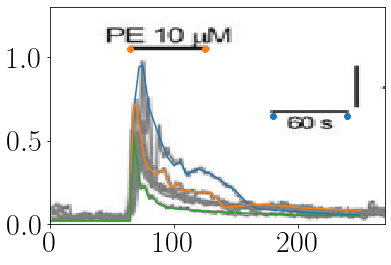

In [4]:
img = mpimg.imread('figures/Screenshots/c_falloff_ex2.png')
plt.imshow(img[0:-10, 10:150], vmin=0, vmax=100, extent=(0, 270, 0, 1.3), aspect='auto')
plt.scatter([180, 240], [0.65, 0.65])

falloff1 = np.array([    
    [0, 65, 66, 67, 68, 72, 75, 80, 87, 95, 100, 105, 107, 110, 120, 130, 140, 150, 160, 165, 170, 190, 230, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.94, 0.95, 0.7, 0.55, 0.4, 0.35, 0.37, 0.35, 0.3, 0.33, 0.3, 0.25, 0.2, 0.12, 0.1, 0.09, 0.08, 0.06, 0.055]
])
falloff2 = np.array([
    [0, 65, 66, 67, 68, 69, 70, 71, 72, 76, 78, 85, 88, 92, 97, 104, 107, 130, 135, 140, 170, 200, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.72, 0.7, 0.65, 0.6, 0.4, 0.35, 0.3, 0.31, 0.33, 0.22, 0.25, 0.2, 0.19, 0.15, 0.1, 0.12, 0.1, 0.08]
])
falloff3 = np.array([
    [0, 65, 66, 67, 68, 69, 72, 73, 77, 80, 83, 88, 94, 105, 140, 200, 250],
    [0.02, 0.02, 0.25, 0.35, 0.52, 0.45, 0.3, 0.21, 0.22, 0.15, 0.16, 0.12, 0.1, 0.09, 0.072, 0.055, 0.05]
])

plt.plot(
    [0, 65, 66, 67, 68, 72, 75, 80, 87, 95, 100, 105, 107, 110, 120, 130, 140, 150, 160, 165, 170, 190, 230, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.94, 0.95, 0.7, 0.55, 0.4, 0.35, 0.37, 0.35, 0.3, 0.33, 0.3, 0.25, 0.2, 0.12, 0.1, 0.09, 0.08, 0.06, 0.055]
)
plt.plot(
    [0, 65, 66, 67, 68, 69, 70, 71, 72, 76, 78, 85, 88, 92, 97, 104, 107, 130, 135, 140, 170, 200, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.72, 0.7, 0.65, 0.6, 0.4, 0.35, 0.3, 0.31, 0.33, 0.22, 0.25, 0.2, 0.19, 0.15, 0.1, 0.12, 0.1, 0.08]
)
plt.plot(
    [0, 65, 66, 67, 68, 69, 72, 73, 77, 80, 83, 88, 94, 105, 140, 200, 250],
    [0.02, 0.02, 0.25, 0.35, 0.52, 0.45, 0.3, 0.21, 0.22, 0.15, 0.16, 0.12, 0.1, 0.09, 0.072, 0.055, 0.05]
)
activation = [65, 125]
plt.scatter(activation, [1.05, 1.05])

Goals to explain
* Factors contributing to falloff
* Stimulation protocol to reproduce falloff in model
* Convincingly answer how much falloff is a result of Ca2+ depletion versus desensitization

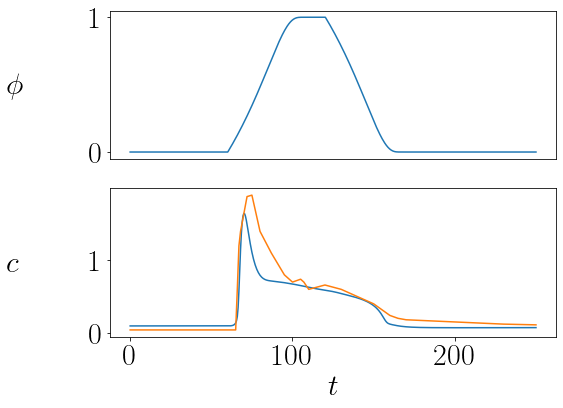

In [14]:
cfg.input_max = 1
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

cfg.kd2 = 0.6
cfg.kd1 = 0.02
run_experiment('exponential_pulse', t_f=250, max_step=0.5)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_experiment_plots(['glut', 'c'], axs=ax)

ax[1].plot(falloff1[0], falloff1[1] * 2)


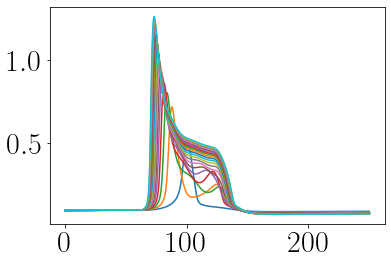

In [8]:
maxes = []
areas = []
for inp in np.linspace(0.01, 0.2, 20):
    cfg.input_max = inp
    run_experiment('exponential_pulse', t_f=250, max_step=0.5)
    
    maxes.append(cfg.c.max())
    areas.append(np.trapz(cfg.c, cfg.t))
    plt.plot(cfg.t, cfg.c)
ratios = np.array(areas) / np.array(maxes)

# Falloff of plateau

Data from Chai et al. 2017, hand converted to data. These stimulations were for 1 minute each, starting at 60s. The gradual falloff of the intracellular calcium suggests that the bath took a while to gradually wash out. (We needed to introduce a 30-50 second gradual decay of glutamate to simulate the same falloff, and even turning off calcium leak parameters did not replicate the falloff without this glutamate ramp down)

## Replicating calcium falloff curve

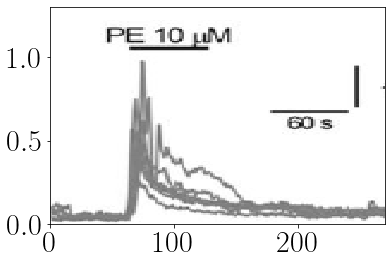

In [30]:
plt.imshow(img[0:-10, 10:150], vmin=0, vmax=100, extent=(0, 270, 0, 1.3), aspect='auto', alpha=1)


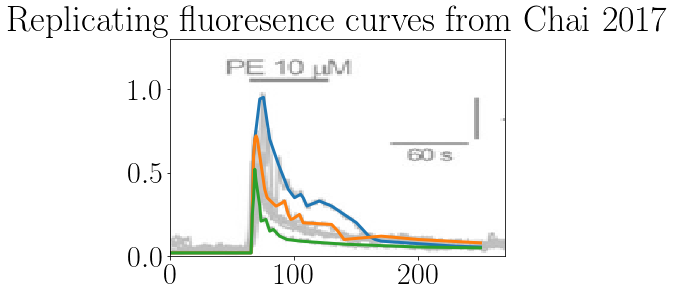

In [5]:
img = mpimg.imread('figures/Screenshots/c_falloff_ex2.png')
plt.imshow(img[0:-10, 10:150], vmin=0, vmax=100, extent=(0, 270, 0, 1.3), aspect='auto', alpha=0.5)
# plt.scatter([180, 240], [0.65, 0.65])


falloff1 = np.array([    
    [0, 65, 66, 67, 68, 72, 75, 80, 87, 95, 100, 105, 107, 110, 120, 130, 140, 150, 160, 165, 170, 190, 230, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.94, 0.95, 0.7, 0.55, 0.4, 0.35, 0.37, 0.35, 0.3, 0.33, 0.3, 0.25, 0.2, 0.12, 0.1, 0.09, 0.08, 0.06, 0.055]
])
falloff2 = np.array([
    [0, 65, 66, 67, 68, 69, 70, 71, 72, 76, 78, 85, 88, 92, 95, 97, 99, 104, 107, 130, 135, 140, 170, 200, 250],
    [0.02, 0.02, 0.3, 0.6, 0.7, 0.72, 0.7, 0.65, 0.6, 0.4, 0.35, 0.3, 0.31, 0.33, 0.25, 0.22, 0.225, 0.25, 0.2, 0.19, 0.15, 0.1, 0.12, 0.1, 0.08]
])
falloff3 = np.array([
    [0, 65, 66, 67, 68, 69, 72, 73, 77, 80, 83, 88, 94, 105, 140, 200, 250],
    [0.02, 0.02, 0.25, 0.35, 0.52, 0.45, 0.3, 0.21, 0.22, 0.15, 0.16, 0.12, 0.1, 0.09, 0.072, 0.055, 0.05]
])

plt.title("Replicating fluoresence curves from Chai 2017")
plt.plot(falloff1[0], falloff1[1], linewidth=3)
plt.plot(falloff2[0], falloff2[1], linewidth=3)
plt.plot(falloff3[0], falloff3[1], linewidth=3)

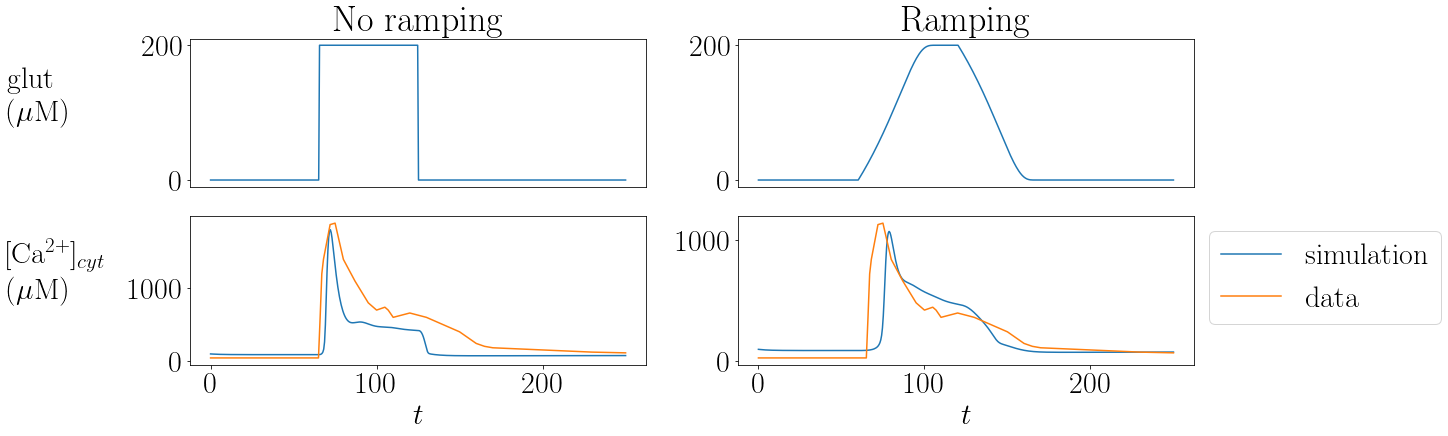

In [3]:
cfg.input_max = 0.2
cfg.input_start = 65
cfg.input_duration = 60
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30

run_experiment('pulse', t_f=250, max_step=0.5)

fig, ax = plt.subplots(2, 2, figsize=(18, 6))
plot_experiment_plots(['glut', 'c'], axs=ax[:, 0])

ax[1, 0].plot(falloff1[0], falloff1[1] * 2 * 1000)

cfg.input_max = 0.2
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

run_experiment('exponential_pulse', t_f=250, max_step=0.5)

plot_experiment_plots(['glut', 'c'], axs=ax[:, 1], legend_label='simulation', add_ylabels=False)

ax[1, 1].plot(falloff1[0], falloff1[1] * 1.2 * 1000, label='data')

ax[1, 1].legend(bbox_to_anchor=(1, 1, 0, 0))

ax[0, 0].set_title('No ramping')
ax[0, 1].set_title('Ramping')

plt.savefig(save + '1.1_replicate_rampdown.png', bbox_inches='tight')


## Measuring effect of parameters on decay

One way to measure decay is the ratio of the area (total calcium) to the max peak. If the ratio is lower, then the calcium response must have decayed over the course of the stimulation (more decay).

The following measure shows that high kd1/kd2 both lead to more decay, but increasing v+ and v- both lead to less decay

In [11]:
variables = ['v_delta', 'v_3k', 'kd1', 'kd2']
variable_labels = ['v$_+$', 'v$_-$', 'k$_{d1}$', 'k$_{d2}$']
default_vals = [getattr(cfg, var) for var in variables]
areas = {}
maxes = {}
c1s = {}
c2s = {}

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


for var in variables:
    areas[var] = []
    maxes[var] = []
    c1s[var] = []
    c2s[var] = []
    
multipliers = np.linspace(0, 2, 20)
for i, var in enumerate(tqdm(variables)):
    for mult in multipliers:
        setattr(cfg, var, default_vals[i] * mult)
        run_experiment('exponential_pulse', t_f=250, max_step=0.5)
        maxes[var].append(cfg.c.max())
        areas[var].append(np.trapz(cfg.c, cfg.t))
        c1s[var].append(capture_c(t1))
        c2s[var].append(capture_c(t2))
    setattr(cfg, var, default_vals[i])

pickle.dump([c1s, c2s, multipliers], open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'wb'))

Examples of effects of changing parameters on plateau decay simulation

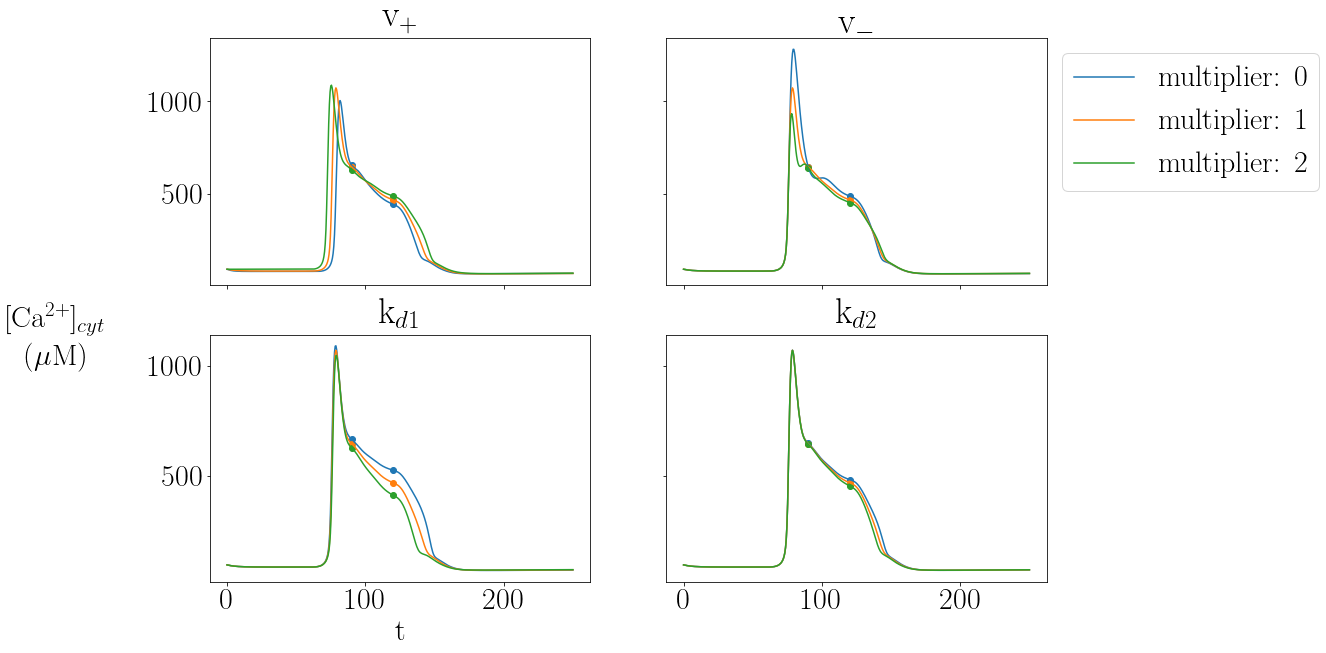

In [37]:
multipliers = np.linspace(0, 2, 3)
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharey='row', sharex=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    for mult in multipliers:
        setattr(cfg, var, default_vals[i] * mult)
        run_experiment('exponential_pulse', t_f=250, max_step=0.5)
        cfg.c = cfg.c * 1000
        ax[x, y].plot(cfg.t, cfg.c, label='multiplier: '+ str(int(mult)))
        ax[x, y].scatter([t1, t2], [capture_c(t1), capture_c(t2)])
    setattr(cfg, var, default_vals[i])
    ax[x, y].set_title(variable_labels[i])

ax[0, 1].legend(bbox_to_anchor=(1, 1, 0, 0))
ax[1, 0].set_xlabel('t')
ax[0, 0].set_ylabel('[Ca$^{2+}$]$_{cyt}$ \n ($\mu$M)', rotation=0, labelpad=30)
ax[0, 0].get_yaxis().set_label_coords(-0.4, -0.35)

# plt.tight_layout()
    
plt.savefig(save + '1.2_visual_variable_example.png', bbox_inches='tight')

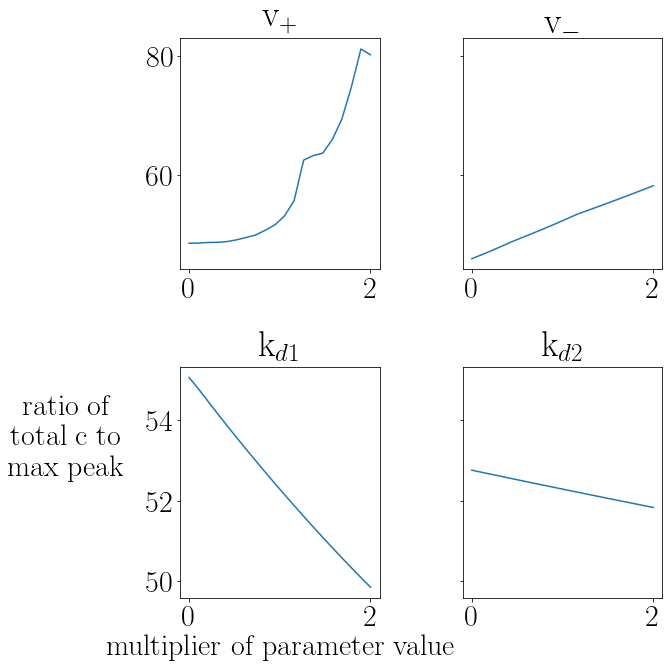

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    ratios = np.array(areas[var]) / np.array(maxes[var])
    ax[x, y].plot(multipliers, ratios)
    ax[x, y].set_title(variable_labels[i])

ax[1, 0].set_ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
ax[1, 0].set_xlabel('multiplier of parameter value')
plt.tight_layout()

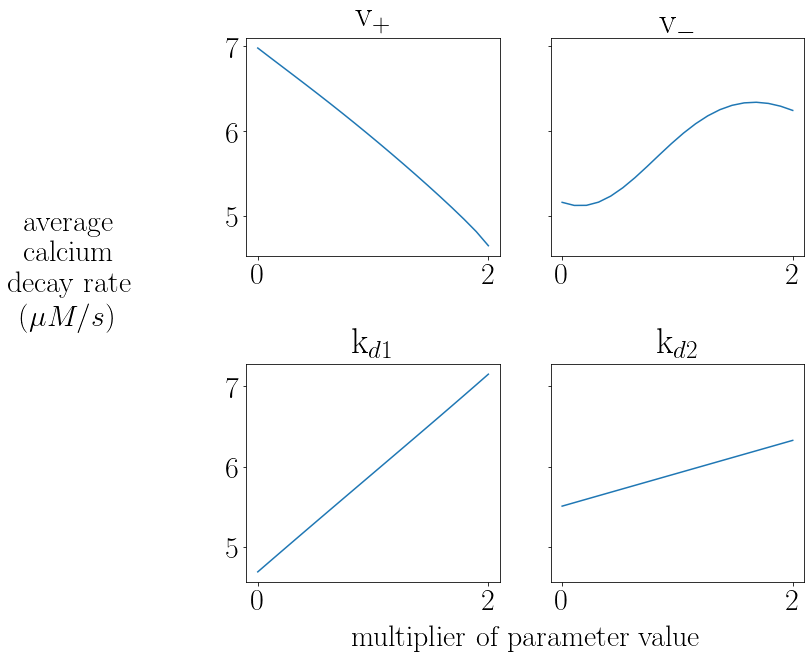

In [10]:
c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
variables = ['v_delta', 'v_3k', 'kd1', 'kd2']
variable_labels = ['v$_+$', 'v$_-$', 'k$_{d1}$', 'k$_{d2}$']
cfg.input_start = 65
cfg.input_duration = 60
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
plt.subplots_adjust(hspace=0.5)
multipliers = np.linspace(0, 2, 20)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    # ratios = np.array(c2s[var]) / np.array(c1s[var])
    ratios = (np.array(c2s[var]) - np.array(c1s[var])) / (t2 - t1)
    ax[x, y].plot(multipliers, -ratios)
    ax[x, y].set_title(variable_labels[i])

# ax[1, 0].set_ylabel('ratio of \n c$_2$ to c$_1$', rotation=0, labelpad=80)
ax[0, 0].set_ylabel('average \n calcium \n decay rate \n ($\mu M / s$)', rotation=0, labelpad=80, )
ax[0, 0].get_yaxis().set_label_coords(-0.7, -0.35)

ax[1, 0].set_xlabel('multiplier of parameter value')
ax[1, 0].get_xaxis().set_label_coords(1.1, -0.2)
# plt.tight_layout()

plt.savefig(save + '1_2_variable_decay_rates.png', bbox_inches='tight')

## Measuring effects of c_ER depletion on decay

The previous results suggest that GPCR desensitization, particularly Gd1 desensitization plays a key role in the falloff of calcium response. The alternative hypothesis is that ER store depletion leads to this gradual falloff of response

As shown below, ER calcium correctly dips

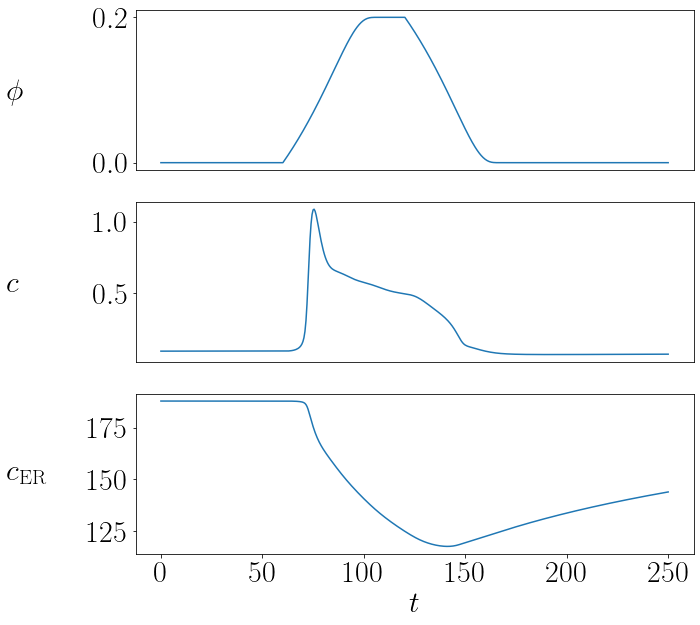

In [8]:
cfg.input_max = 0.2
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

run_experiment('exponential_pulse', t_f=250, max_step=0.5)

plot_experiment_plots(['glut', 'c', 'c_er'])

fix_c_er = cfg.c_er

We can manually increase or decrease the drain rate of ER storage calcium by setting the ER values to be a constant multiple of the original ER calcium recorded from the control condition.

Here we either stop the ER drain (orange) or double it (green). Note that although this shows clear increases in decay
1. Because we are fixing ER values, this does not reflect completely accurate dynamics (the dynamics of the c_ER would not follow the exact curve)

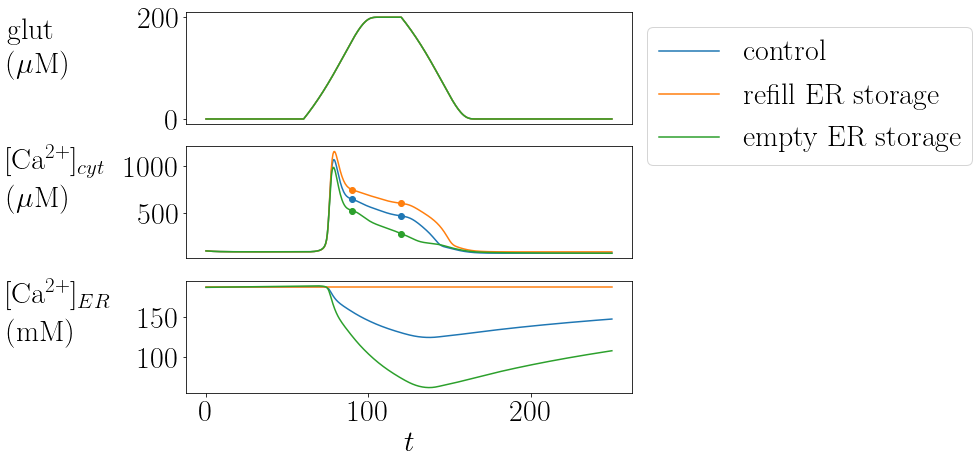

In [4]:
cfg.input_max = 0.2
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


fig, ax = plt.subplots(3, 1, figsize=(8, 7))

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax, legend_label='control')
fix_c_er = cfg.c_er
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

mult = 0
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax, legend_label='refill ER storage')
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

mult = 2
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax, legend_label='empty ER storage')
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

ax[0].legend(bbox_to_anchor=(1, 1, 0, 0))

plt.savefig(save + '1.3_depletion_example.png', bbox_inches='tight')


We use the same measure of total c versus max peak to see that indeed, the ER storage does have an effect on the dropoff. We can also compare this to the Gd1 curve. Effectively this says that "doubling the drain rate" of ER would lead ot more dropoff than doubling the Gd1 desensitization strength.

However

2. Affective the ER storage this way is a much more biologically drastic change than the slight adjustment to the Gd1 parameter. Imagine a never ending supply of ER calcium (drain rate = 0), this is a very different system than a normal one

In [13]:
maxes2 = []
areas2 = []
c1s2 = []
c2s2 = []
multipliers = np.linspace(0, 2, 20)
# multipliers = np.linspace(0, 2, 3)
for mult in multipliers:
    inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)

    maxes2.append(cfg.c.max())
    areas2.append(np.trapz(cfg.c, cfg.t))
    c1s2.append(capture_c(t1))
    c2s2.append(capture_c(t2))
    
pickle.dump([c1s2, c2s2, multipliers], open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'wb'))

Text(0, 0.5, 'ratio of \n total c to \n max peak')

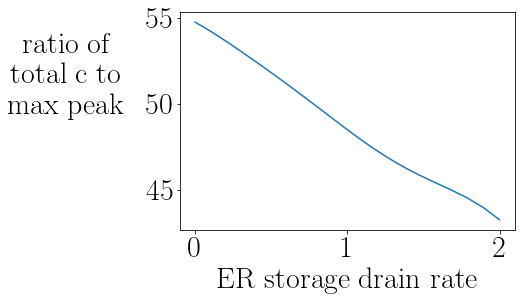

In [10]:

plt.plot(multipliers, np.array(areas2) / np.array(maxes2))
plt.xlabel('ER storage drain rate')
plt.ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)

Text(0.5, 0, 'k$_{d1}$ multiplier')

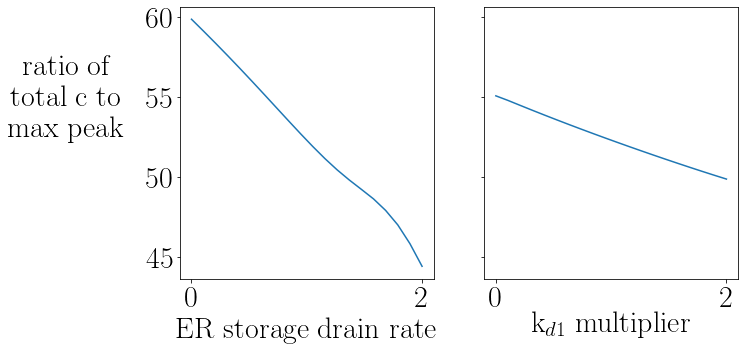

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax[0].plot(multipliers, np.array(areas2) / np.array(maxes2))
ax[0].set_xlabel('ER storage drain rate')
ax[0].set_ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)

ax[1].plot(multipliers, np.array(areas['kd1'] / np.array(maxes['kd1'])))
ax[1].set_xlabel('k$_{d1}$ multiplier')

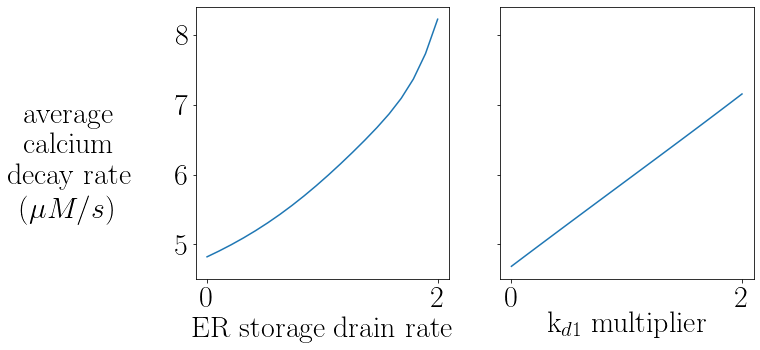

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
c1s2, c2s2, _ = pickle.load(open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'rb'))


ratios = (np.array(c2s2) - np.array(c1s2)) / (t2 - t1)
ax[0].plot(multipliers, -ratios)
ax[0].set_xlabel('ER storage drain rate')
ax[0].set_ylabel('average \n calcium \n decay rate \n ($\mu M / s$)', 
                    rotation=0)
ax[0].get_yaxis().set_label_coords(-0.5, 0.2)

ratios = (np.array(c2s['kd1']) - np.array(c1s['kd1'])) / (t2 - t1)
ax[1].plot(multipliers, -ratios)
ax[1].set_xlabel('k$_{d1}$ multiplier')

plt.savefig(save + '1.3_plateau_er_kd1_comparison.png', bbox_inches='tight')

## Comparison of Gd1 vs ER depletion

with Gd1 turned off or ER depletion turned off, see what happens as glutamate ramps up

In [21]:
cases

['control', 'no ER depletion', 'no Gd1', 'no ER depletion or Gd1']

In [35]:
cases[1] == 'no ER depletion'

True

0.02
0


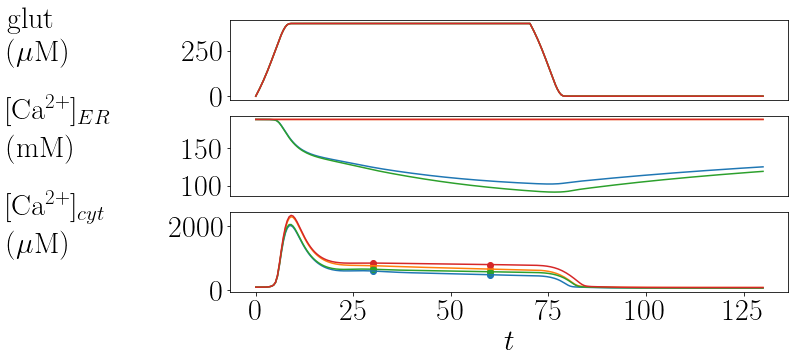

In [41]:
# for glut in tqdm(gluts):
glut = 0.2
cfg.input_max = glut
fig, axs = plt.subplots(3, 1, figsize=(10, 5))
for case in cases:
# for case in ['control', 'no ER depletion', 'no Gd1']:
    # print(case)
    if case == 'control' or case == 'no ER depletion':
        cfg.kd1 = 0.02
    else:
        cfg.kd1 = 0

    if case == 'no ER depletion' or case == 'no ER depletion or Gd1':
        # print('no depletion')
        print(cfg.kd1)
        run_experiment('exponential_pulse', t_f=130, max_step=0.5, fix_c_er=187.816)
    else:
        run_experiment('exponential_pulse', t_f=130, max_step=0.5)
        
    plot_experiment_plots(['glut', 'c_er', 'c'], axs=axs)
    axs[2].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

In [42]:
gluts = np.linspace(0.01, 1, 50)
cases = ['control', 'no ER depletion', 'no Gd1', 'no ER depletion or Gd1']
areas = {}
maxes = {}
c1s = {}
c2s = {}

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30

for case in cases:
    areas[case] = []
    maxes[case] = []
    c1s[case] = []
    c2s[case] = []
    
for glut in tqdm(gluts):
    cfg.input_max = glut
    for case in cases:
        if case == 'control' or case == 'no ER depletion':
            cfg.kd1 = 0.02
        else:
            cfg.kd1 = 0
        
        if case == 'no ER depletion' or case == 'no ER depletion or Gd1':
            run_experiment('exponential_pulse', t_f=130, max_step=0.5, fix_c_er=187.816)
        else:
            run_experiment('exponential_pulse', t_f=130, max_step=0.5)
        # print(case)
        maxes[case].append(cfg.c.max())
        areas[case].append(np.trapz(cfg.c, cfg.t))
        c1s[case].append(capture_c(t1))
        c2s[case].append(capture_c(t2))
        
        cfg.kd1 = 0.02
cfg.input_max = 0.2

pickle.dump([c1s, c2s, areas, maxes, cases], open('data/plot_data/falloff/1.4_on_off_comparison', 'wb'))
            

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.19it/s]


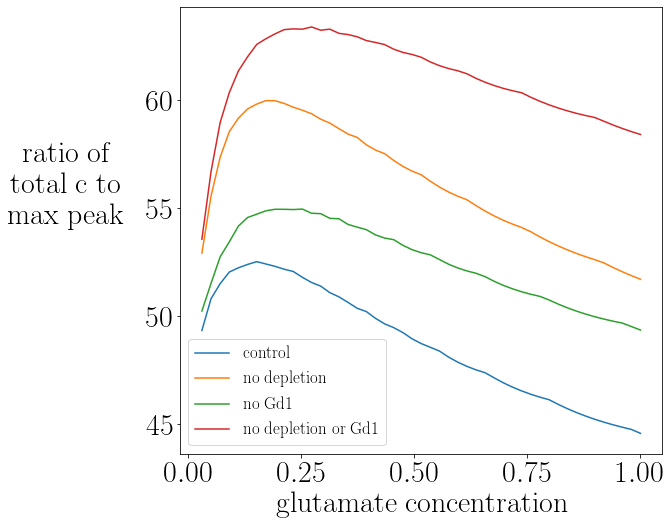

In [71]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
c1s, c2s, areas, maxes, cases = pickle.load(open('data/plot_data/falloff/1.4_on_off_comparison', 'rb'))

plt.figure(figsize=(10, 8))

start_idx = 1

for i, case in enumerate(cases):
    x = i // 2
    y = i % 2
    ratios = np.array(areas[case]) / np.array(maxes[case])
    # ax[x, y].plot(gluts, ratios)
    plt.plot(gluts[start_idx:], ratios[start_idx:], label=case)
    # ax[x, y].set_title(case)

# ax[1, 0].set_ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
# ax[1, 0].set_xlabel('glutamate concentration')
plt.ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
plt.xlabel('glutamate concentration')

plt.legend(fontsize=17)

plt.tight_layout()

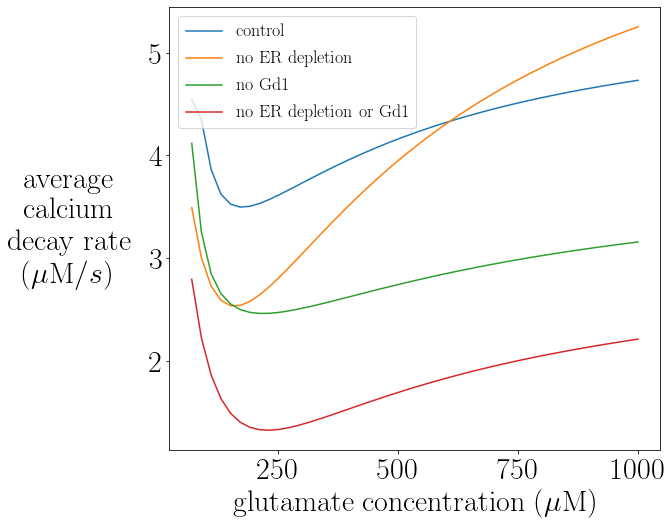

In [43]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30
c1s, c2s, areas, maxes, cases = pickle.load(open('data/plot_data/falloff/1.4_on_off_comparison', 'rb'))

plt.figure(figsize=(10, 8))

start_idx = 3

for i, case in enumerate(cases):
    x = i // 2
    y = i % 2
    ratios = (np.array(c2s[case]) - np.array(c1s[case])) / (t2 - t1)
    # ax[x, y].plot(gluts, ratios)
    plt.plot(gluts[start_idx:] * 1000, -ratios[start_idx:], label=case)
    # ax[x, y].set_title(case)

# ax[1, 0].set_ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
# ax[1, 0].set_xlabel('glutamate concentration')
# plt.ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
plt.ylabel('average \n calcium \n decay rate \n ($\mu$M$/s$)', rotation=0, labelpad=80, va='center')
plt.xlabel('glutamate concentration ($\mu$M)')

plt.legend(fontsize=18)

plt.tight_layout()

plt.savefig(save + '1.4_on_off_rate_comparison.png', bbox_inches='tight')

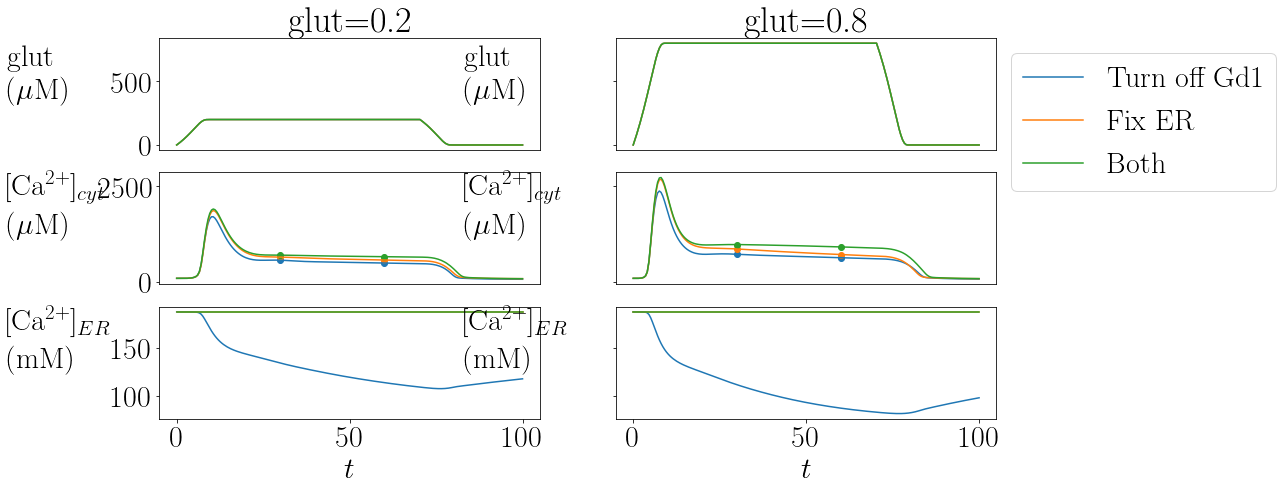

In [10]:

c1s, c2s, areas, maxes, cases = pickle.load(open('data/plot_data/falloff/1.4_on_off_comparison', 'rb'))

cfg.kd1 = 0
fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharey='row')
cfg.input_duration = 60
cfg.input_max = 0.2

ax[0, 0].set_title('glut=0.2')
ax[0, 1].set_title('glut=0.8')
run_experiment('exponential_pulse', t_f=100, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0], add_ylabels=False)
ax[1, 0].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

cfg.kd1 = 0.02
run_experiment('exponential_pulse', t_f=100, max_step=0.5)
fix_c_er = cfg.c_er
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])


fix_c_er = cfg.c_er
mult = 0
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=100, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])
ax[1, 0].scatter([t1, t2], [capture_c(t1), capture_c(t2)])


cfg.kd1 = 0
run_experiment('exponential_pulse', t_f=100, max_step=0.5)
run_experiment('exponential_pulse', t_f=100, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])
cfg.kd1 = 0.02
ax[1, 0].scatter([t1, t2], [capture_c(t1), capture_c(t2)])


cfg.kd1 = 0
# fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharey='row')

cfg.input_max = 0.8

run_experiment('exponential_pulse', t_f=100, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], add_ylabels=False, legend_label='Turn off Gd1')
ax[1, 1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

cfg.kd1 = 0.02
run_experiment('exponential_pulse', t_f=100, max_step=0.5)
fix_c_er = cfg.c_er
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])


fix_c_er = cfg.c_er
mult = 0
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=100, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], legend_label='Fix ER', add_ylabels=False)
ax[1, 1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])


cfg.kd1 = 0
run_experiment('exponential_pulse', t_f=100, max_step=0.5)
run_experiment('exponential_pulse', t_f=100, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], legend_label='Both', add_ylabels=False)
cfg.kd1 = 0.02
ax[1, 1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])


ax[0, 1].legend(bbox_to_anchor=(1, 1, 0, 0))



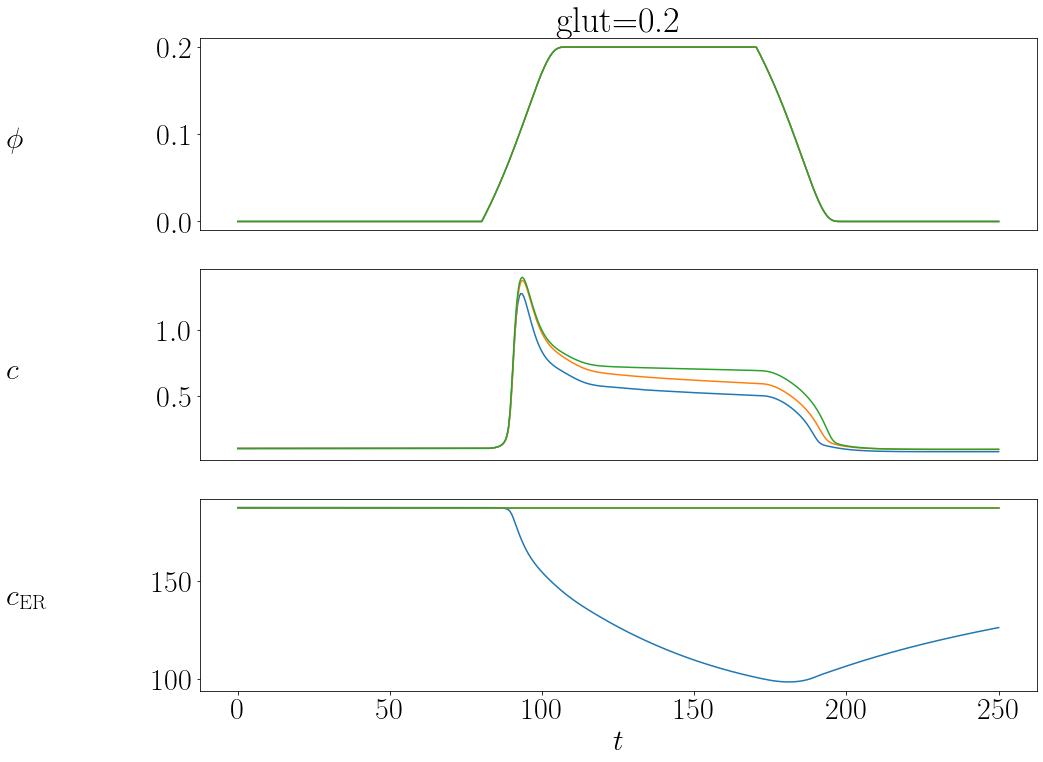

In [53]:
cfg.kd1 = 0
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharey='row')
cfg.input_duration = 60
cfg.input_max = 0.2

ax[0].set_title('glut=0.2')
# ax[0, 1].set_title('glut=0.8')
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:], add_ylabels=False)

cfg.kd1 = 0.02
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
fix_c_er = cfg.c_er
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])


fix_c_er = cfg.c_er
mult = 0
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:])

cfg.kd1 = 0
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:])
cfg.kd1 = 0.02


# cfg.kd1 = 0
# # fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharey='row')

# cfg.input_max = 0.8

# run_experiment('exponential_pulse', t_f=250, max_step=0.5)
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], add_ylabels=False, legend_label='Turn off Gd1')

# cfg.kd1 = 0.02
# run_experiment('exponential_pulse', t_f=250, max_step=0.5)
# fix_c_er = cfg.c_er
# # plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])


# fix_c_er = cfg.c_er
# mult = 0
# inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
# run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], legend_label='Fix ER')


# cfg.kd1 = 0
# run_experiment('exponential_pulse', t_f=250, max_step=0.5)
# run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], legend_label='Both')
# cfg.kd1 = 0.02


# ax[0, 1].legend(bbox_to_anchor=(1, 1, 0, 0))



multiple glutamate durations and amplitudes, measure slope from start of stim to 3/4 through, as well as peak. See if it holds for multiple input types, and see if the peak 

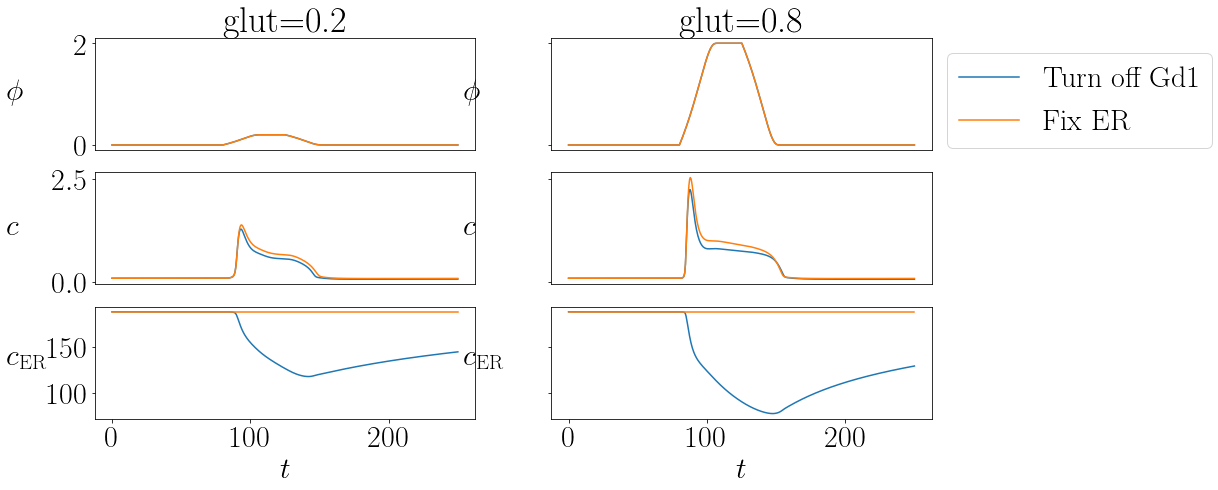

In [47]:
cfg.kd1 = 0
fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharey='row')

cfg.input_max = 0.2

ax[0, 0].set_title('glut=0.2')
ax[0, 1].set_title('glut=0.8')
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0], add_ylabels=False)

cfg.kd1 = 0.02
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
fix_c_er = cfg.c_er
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])


fix_c_er = cfg.c_er
mult = 0
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)

plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])

cfg.kd1 = 0
# fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharey='row')

cfg.input_max = 2

# ax[0, 0].set_title('Fix ER')
# ax[0, 1].set_title('Turn off Gd1')
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], add_ylabels=False, legend_label='Turn off Gd1')

cfg.kd1 = 0.02
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
fix_c_er = cfg.c_er
# plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 0])


fix_c_er = cfg.c_er
mult = 0
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)

plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax[:, 1], legend_label='Fix ER')

ax[0, 1].legend(bbox_to_anchor=(1, 1, 0, 0))



## Conclusion

Gd1 and ER have important roles in the falloff of these plateau type responses

## Adding noise

First compute the mean number of spontaneous spikes generated at different levels of noise when simulated for 500s

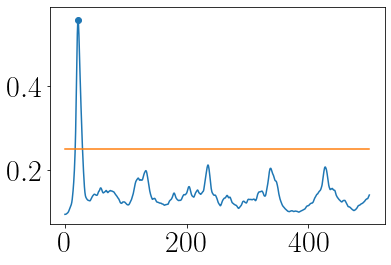

In [12]:
cfg.input_max = 0
run_experiment('pulse', t_f=500, max_step=0.5, noise=0.03)
plt.plot(cfg.t, cfg.c)
spike_detect_lim  = 0.25
plt.plot([0, 500], [0.25, 0.25])
spikes = scipy.signal.find_peaks(cfg.c)[0]
c_spikes = spikes[cfg.c[spikes] > spike_detect_lim]
plt.scatter(cfg.t[c_spikes], cfg.c[c_spikes])

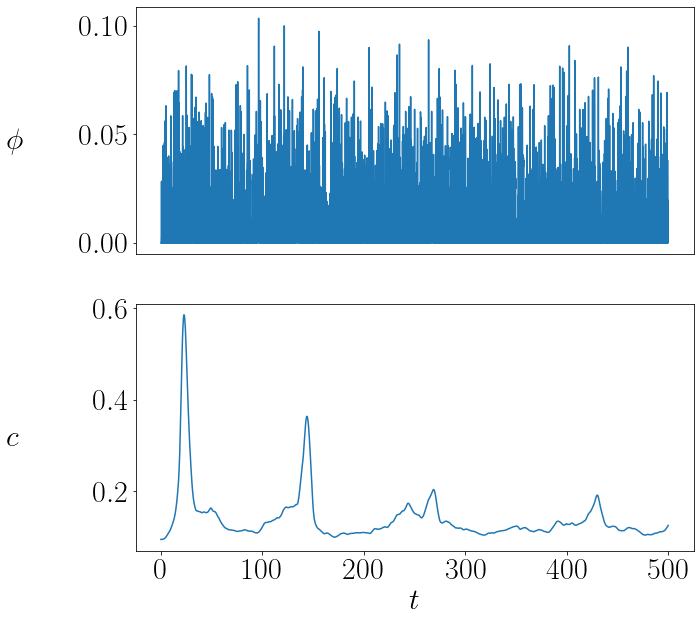

In [13]:
cfg.input_max = 0
run_experiment('pulse', t_f=500, max_step=0.5, noise=0.03)
plot_experiment_plots(['glut', 'c'])

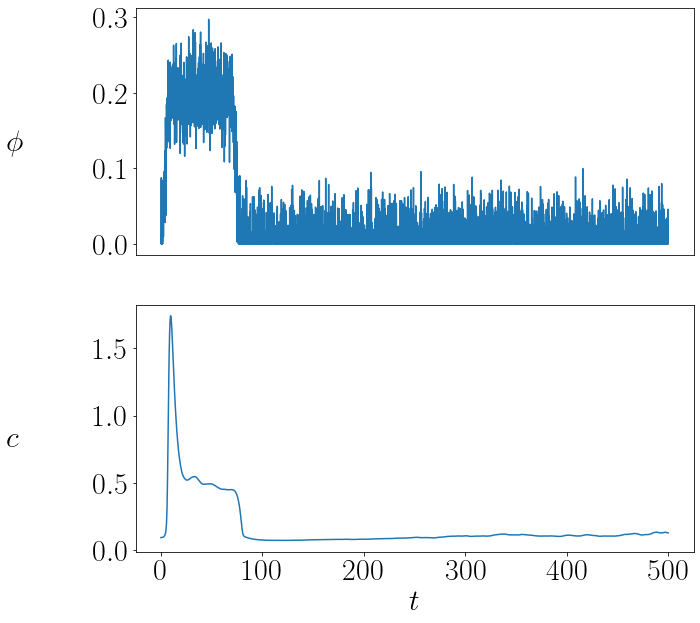

In [14]:
cfg.input_max = 0.2
run_experiment('exponential_pulse', t_f=500, max_step=0.5, noise=0.03)
plot_experiment_plots(['glut', 'c'])

In [112]:
cfg.input_max = 0
noises = np.linspace(0, 0.1, 20)
spike_detect_lim = 0.25
num_trials = 10

num_spikes = {}
for noise in noises:
    num_spikes[noise] = []


def detect_num_spikes(spike_detect_lim=0.25):
    '''
    return number of spikes and spike indices
    '''
    spikes = scipy.signal.find_peaks(cfg.c)[0]
    c_spikes = spikes[cfg.c[spikes] > spike_detect_lim]
    return len(c_spikes), c_spikes


for noise in tqdm(noises):
    for trial in range(num_trials):
        run_experiment('pulse', t_f=500, max_step=0.5, noise=noise)
        num, _ = detect_num_spikes(spike_detect_lim)
        num_spikes[noise].append(num)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.01s/it]


Text(0.5, 0, 'glutamate noise standard deviation')

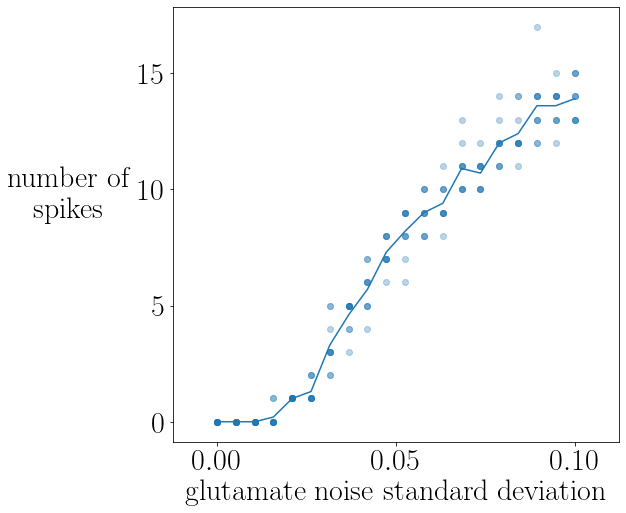

In [118]:
xs = []
ys = []
means = []
plt.figure(figsize=(8, 8))
for noise in noises:
    means.append(np.mean(num_spikes[noise]))
    for i in range(num_trials):
        xs.append(noise)
        ys.append(num_spikes[noise][i])
plt.scatter(xs, ys, alpha=0.3)
plt.plot(noises, means)
plt.ylabel('number of \n spikes', rotation=0, labelpad=70)
plt.xlabel('glutamate noise standard deviation')

### Set level of noise for mean of 2 spikes per 500s
This will roughly be at the 0.025 standard deviation. Unfortunately even with this relatively low level of feedback, it becomes hard to detect differences

In [44]:
gluts = np.linspace(0.01, 1, 25)
noise = 0.025
num_trials = 10

cases = ['control', 'no ER depletion', 'no Gd1', 'no ER depletion or Gd1']
areas = {}
maxes = {}
c1s = {}
c2s = {}
for case in cases:
    areas[case] = {}
    maxes[case] = {}
    c1s[case] = {}
    c2s[case] = {}
    for glut in gluts:
        areas[case][glut] = []
        maxes[case][glut] = []
        c1s[case][glut] = []
        c2s[case][glut] = []
        
for glut in tqdm(gluts):
    cfg.input_max = glut
    for case in cases:
        for i in range(num_trials):
            if case == 'control' or case == 'no ER depletion':
                cfg.kd1 = 0.02
            else:
                cfg.kd1 = 0

            if case == 'no ER depletion' or case == 'no ER depletion or Gd1':
                run_experiment('exponential_pulse', t_f=130, max_step=0.5, fix_c_er=187.816, noise=noise)
            else:
                run_experiment('exponential_pulse', t_f=130, max_step=0.5, noise=noise)

            maxes[case][glut].append(cfg.c.max())
            areas[case][glut].append(np.trapz(cfg.c, cfg.t))
            c1s[case][glut].append(capture_c(t1))
            c2s[case][glut].append(capture_c(t2))

            cfg.kd1 = 0.02

cfg.input_max = 0.2

save_data = [cases, areas, maxes, c1s, c2s, gluts, noise] 
pickle.dump(save_data, file=open('data/plot_data/noisy_plateau_falloff', 'wb'))    

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:30<00:00,  6.03s/it]


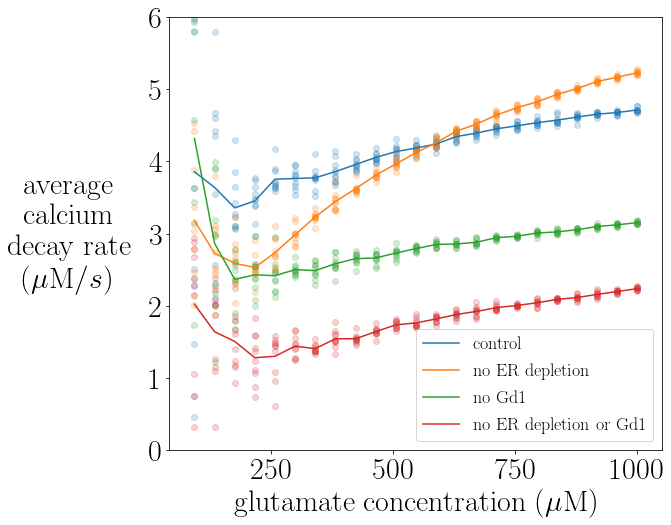

In [66]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
cases, areas, maxes, c1s, c2s, gluts, noise = pickle.load(open('data/plot_data/noisy_plateau_falloff', 'rb'))

plt.figure(figsize=(10, 8))

start_idx = 2
num_trials = 10
for i, case in enumerate(cases):
    xs = []
    ys = []
    means = []
    for j, glut in enumerate(gluts):
        if j >= start_idx:
            ratios = list((np.array(c2s[case][glut]) - np.array(c1s[case][glut])) / (t2 - t1))
            xs = xs + [glut] * 10
            ys = ys + ratios
            means.append(np.mean(ratios))

    # ax[x, y].plot(gluts, ratios)
    plt.scatter(np.array(xs) * 1000, -np.array(ys), alpha=0.2)
    plt.plot(gluts[start_idx:] * 1000, -np.array(means), label=case)
    # ax[x, y].set_title(case)

# ax[1, 0].set_ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
# ax[1, 0].set_xlabel('glutamate concentration')
# plt.ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
plt.ylabel('average \n calcium \n decay rate \n ($\mu$M$/s$)', rotation=0, labelpad=80, va='center')
plt.xlabel('glutamate concentration ($\mu$M)')

plt.legend(fontsize=18)
plt.ylim([0, 6])
plt.tight_layout()

plt.savefig(save + '1.6_on_off_comparison_noise.png', bbox_inches='tight')

# Oscillation falloff

The next type of falloff we want to explore is the falloff of oscillation amplitudes, same reasoning - check if there is a GPCR adaptation that causes this.

In one of the papers (Pasti 1997), they provide the following data for calcium spikes using a step-wise ramping ATP stimulation

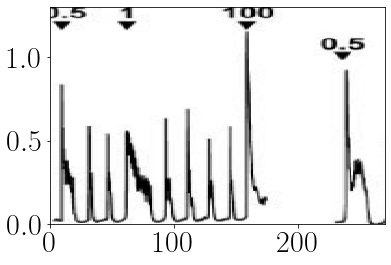

In [277]:
img = mpimg.imread('figures/Screenshots/c_spike_falloff_ex2.png')
plt.imshow(img[160:-45, 40:220], vmin=0, vmax=100, extent=(0, 270, 0, 1.3), aspect='auto')
# plt.scatter([180, 240], [0.65, 0.65])
# spikes1 = np.array([
#     [0, 7, 9.5, 10, 11, 12, 19, 21, 23, 25, 29, 34, 37, 39,
#     41, 43, 49, 55, 63, 65, 66, 75, 82, 92, 94, 95, 96, 98, 105],
#     [0.1, 0.1, 0.7, 1, 0.7, 0.1, 0.1, 0.79, 0.4, 0.1, 0.1, 0.11, 0.13, 0.7,
#     0.45, 0.08, 0.08, 0.09, 0.13, 0.65, 0.08, 0.08, 0.09, 0.1, 0.13, 0.15, 0.63, 0.08, 0.09]
# ])

# plt.plot(spikes1[0], spikes1[1], linewidth=2)


It is hard for our model to produce an exact replica of this type of response, but we do see sometimes a sort of plateau falloff before oscillations pick up (kind of like oscillation delay induced by negative calcium to IP3 feedback)

**One of the large issues we have is that the amplitude of spikes following the first are significantly smaller than the first (60-70% smaller), whereas in the data this they are only 25-40% smaller.**

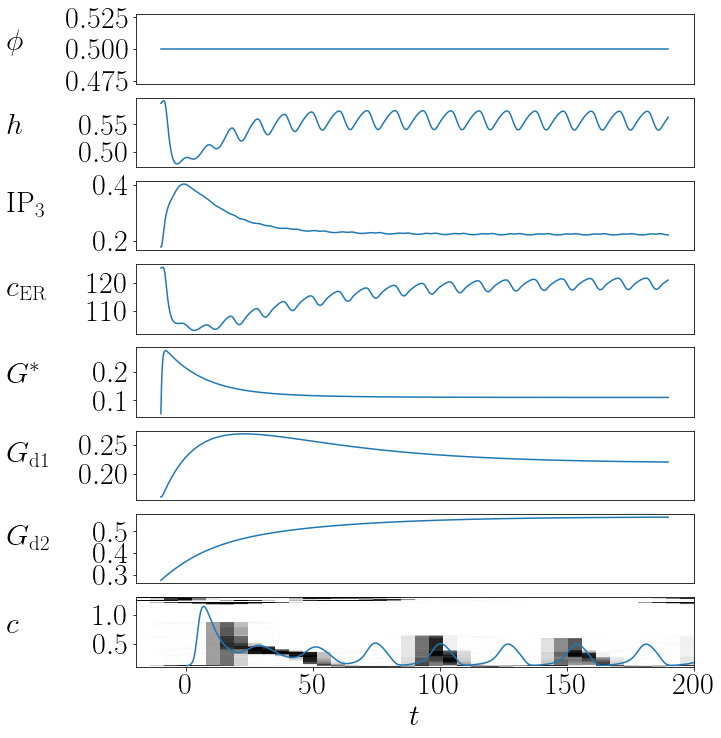

In [366]:
cfg.input_duration = 1000
cfg.input_max = 0.5
cfg.input_start = 0
fig, ax = plt.subplots(8, 1, figsize=(10, 12))
# set_init('poisson')
# cfg.all_init[1] = cfg.all_init[1] * 0.6
# cfg.all_init = all_init2
cfg.all_init = all_init3

cfg.kd2 = 2.4
cfg.v_delta = 0.005
cfg.v_3k = 0.05

# run_experiment('step', t_f=500, max_step=0.5)
run_experiment('exponential_pulse', t_f=500, max_step=0.5)

plot_experiment_plots(['glut', 'h', 'p', 'c_er', 'Gstar', 'Gd1', 'Gd2', 'c'], axs=ax)
# ax[1].plot(spikes1[0] * 2.4 - 10, spikes1[1] * 0.7)
ax[7].imshow(img[160:-45, 40:80], vmin=0, vmax=100, extent=(-20, 200, 0.1, 1.3), aspect='auto')
# ax[1].set_xlim([0, 500])

cfg.kd2 = 0.6
cfg.v_3k = 0.1
cfg.v_delta = 0.01
set_init('default')

## Tracking peaks and amplitudes

In [47]:
cfg.input_start = -10
cfg.input_max = 0.1
cfg.input_duration = 1000

ranges = [np.linspace(0, 0.2, 30),
np.linspace(0, 0.02, 30),
np.linspace(0, 0.04, 30),
np.linspace(0, 2.4, 30)]
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]

# v3ks = np.linspace(0, 0.2, 10)
# vdeltas = np.linspace(0, 0.02, 10)
# kd1s = np.linspace(0, 0.04, 10)
# kd2s = np.linspace(0, 2.4, 10)

set_init('poisson')
# cfg.all_init = all_init3
# cfg.all_init = [0.11909532339511657,
#  23.28081394731322,
#  0.5885149421133017,
#  0.17761312473773083,
#  0.05217067363760168,
#  0.15905260305735866,
#  0.2744065020998043,
#  0.004039453889399858] #after 0.2 noise

all_t_peaks = {}
all_c_peaks = {}
decays = {}
decay_rates = {}
for var in variables:
    all_t_peaks[var] = []
    all_c_peaks[var] = []
    decays[var] = []
    decay_rates[var] = []

for j, var in enumerate(tqdm(variables)):
    for i, reset_var in enumerate(variables):
        setattr(cfg, reset_var, default_vals[i])
    rnge = ranges[j]
    
    for val in rnge:
        setattr(cfg, var, val)
        run_experiment('pulse', t_f=250, max_step=0.5)
        
        # peaks = scipy.signal.find_peaks(cfg.c)[0]
        # return_low_lim = 200 #how far does calcium have to return before we consider
        #                      #ourselves to be in standard oscillation range
        # first_peak = np.argmax(cfg.c[peaks])
        # second_largest = np.argmax(cfg.c[peaks[first_peak]:)
        # return_low = np.argmax(cfg.c[peaks[first_peak]:] < return_low_lim)
        # if return_low == 0:
        #     osc_start = -1
        # else:
        #     osc_start = first_peak + return_low
        # peaks = np.append([first_peak], scipy.signal.find_peaks(cfg.c[osc_start:])[0] + osc_start)
        
        peaks = scipy.signal.find_peaks(cfg.c)[0]
        c_peaks = cfg.c[peaks]
        max_idx = np.argmax(c_peaks)
        peaks = peaks[max_idx:]
        second_largest = np.argmax(cfg.c[peaks[1:]]) + 1
        second_largest_c = cfg.c[peaks[second_largest]]
        second_largest_t = cfg.t[peaks[second_largest]]
        
        
        
        c_peaks = cfg.c[peaks]
        t_peaks = cfg.t[peaks]
        
        all_t_peaks[var].append(t_peaks)
        all_c_peaks[var].append(c_peaks)
        decays[var].append(c_peaks[-1] - second_largest_c)
        decay_rates[var].append((c_peaks[-1] - second_largest_c) / (cfg.t[peaks[-1]] - second_largest_t))
        
    

pickle.dump(decays, open('data/plot_data/falloff/2.1_oscillation_var', 'wb'))

**Using poisson conditions**

For the following, we run a bath experiment (no ramping) starting from non-steady state conditions (conditions as if the cell has received some weak poisson-train stimulation). The glutamate stimulation is at 100$\mu M$. 

Often, there is first a plateau-like transient before oscillations begin, so we only count oscillations after the calcium has managed to reset below the 0.2 level (marked in orange)

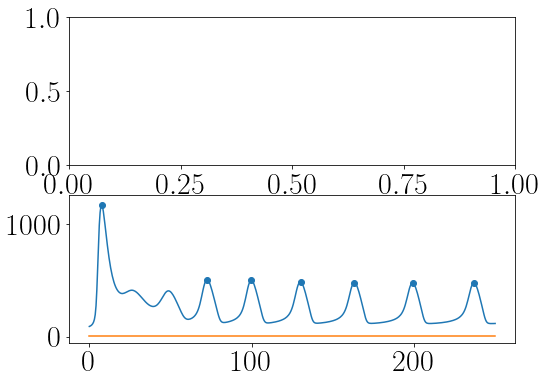

In [75]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

plt.plot(cfg.t, cfg.c)
plt.plot([0, cfg.t[-1]], [0.2, 0.2])
plt.scatter(cfg.t[peaks], cfg.c[peaks])

red_peaks = [peaks[1], peaks[-1]]
# plt.scatter(cfg.t[red_peaks], cfg.c[red_peaks], c='red')

Here, each of the valid peaks are plotted, and we vary parameter values for $v_-, v_+, k_{d1}, k_{d2}$

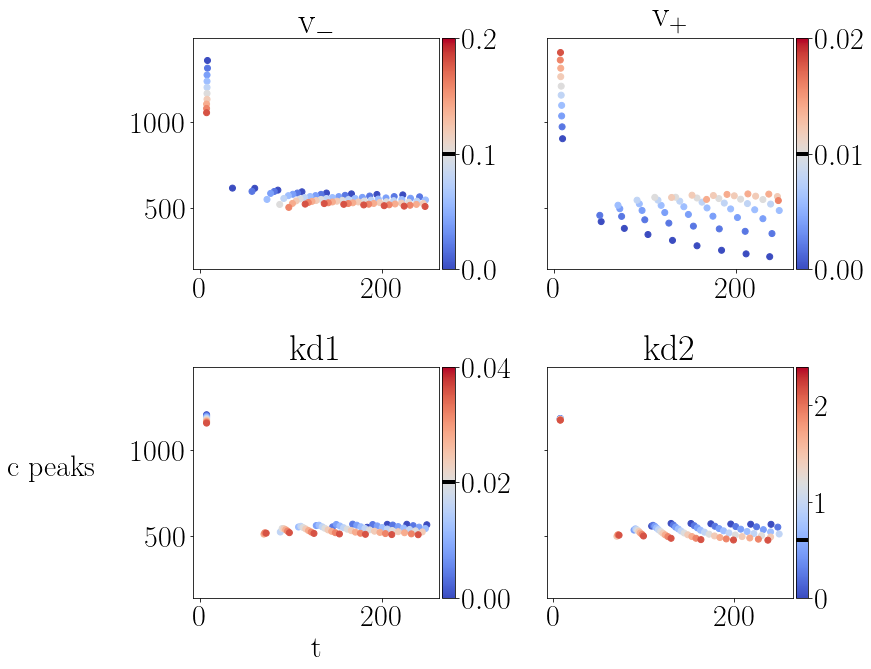

In [76]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = matplotlib.cm.get_cmap('coolwarm')
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    for j, val in enumerate(rnge):
        color = cmap((j)/len(rnge))
        ax[x, y].scatter(all_t_peaks[var][j], all_c_peaks[var][j], c=[color]*len(all_c_peaks[var][j]))
    ax[x, y].set_title(labels[i])
    
    divider = make_axes_locatable(ax[x, y])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    norm = matplotlib.colors.Normalize(vmin=rnge[0], vmax=rnge[-1])
    matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    # fig.colorbar(im1, cax=cax, orientation='vertical')
    cax.plot([0, 10], [default_vals[i], default_vals[i]], c='k', linewidth=4)


ax[1, 0].set_xlabel('t')
ax[1, 0].set_ylabel('c peaks', rotation=0, labelpad=80)

plt.tight_layout()
        

The same plot but plotted as lines. Here, it seems like there is more decay for smaller values of $v_+$ and larger values of $k_{d2}$

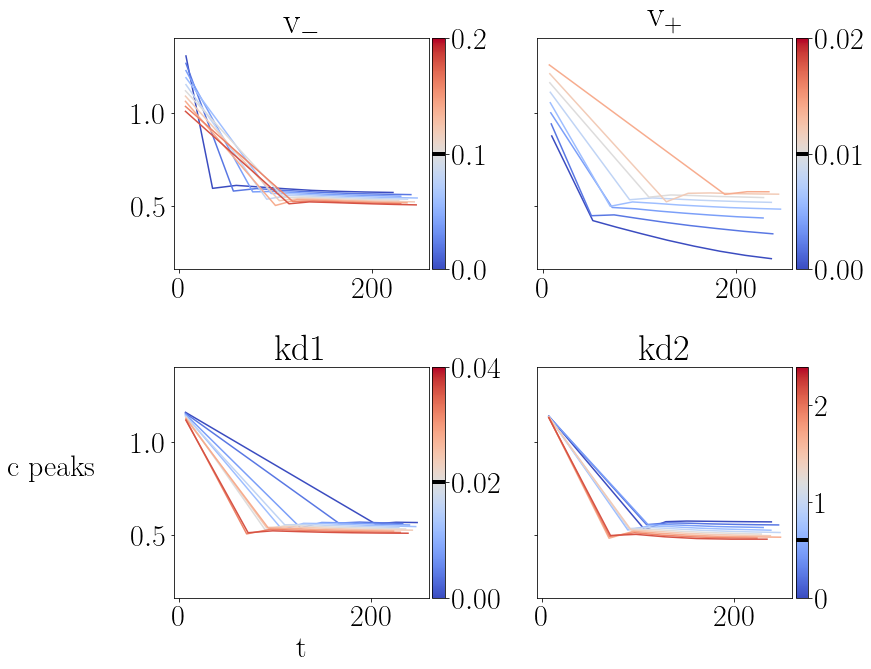

In [479]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = matplotlib.cm.get_cmap('coolwarm')
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    for j, val in enumerate(rnge):
        color = cmap((j)/len(rnge))
        # ax[x, y].scatter(all_t_peaks[var][j], all_c_peaks[var][j], c=[color]*len(all_c_peaks[var][j]))
        ax[x, y].plot(all_t_peaks[var][j], all_c_peaks[var][j], c=color)

    ax[x, y].set_title(labels[i])
    
    divider = make_axes_locatable(ax[x, y])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    norm = matplotlib.colors.Normalize(vmin=rnge[0], vmax=rnge[-1])
    matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    # fig.colorbar(im1, cax=cax, orientation='vertical')
    
    cax.plot([0, 10], [default_vals[i], default_vals[i]], c='k', linewidth=4)

ax[1, 0].set_xlabel('t')
ax[1, 0].set_ylabel('c peaks', rotation=0, labelpad=80)

plt.tight_layout()
        

## Mean changes of ampltiude from second peak to last

To avoid tracking the initial plateau that sometimes occurs, we consider only peaks that happen after the calcium level resets below 0.2 (orange line).

In the following plots, we consider the decay of calcium amplitude between the first peak after orange and the last peak reached. The difference of these peak heights is what we term "amplitude decay".

We also track the same first and last peaks for interspike intervals (ISIs).

**Results**

The $v_+$ parameter, specifically weakening it, seems to be the most important factor for decreasing in amplitude. This is in line with our previous exploration seeing that $v_+$ being lower allows for greater amplitude range based on the bifurcation diagram

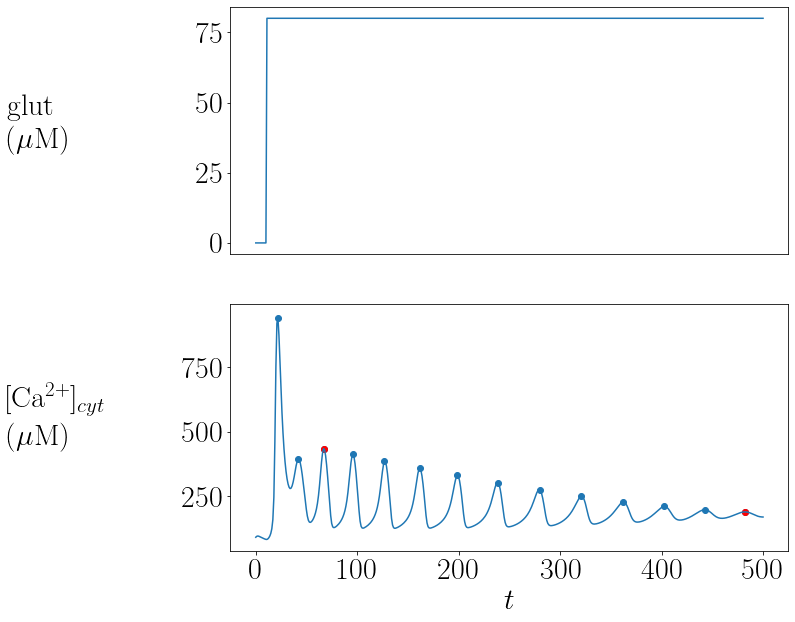

In [77]:
cfg.input_max = 0.08
cfg.input_start = 10
cfg.input_duration = 9000
set_init('poisson')
run_experiment('pulse', t_f=500, max_step=1)
peaks = scipy.signal.find_peaks(cfg.c)[0]
c_peaks = cfg.c[peaks]
max_idx = np.argmax(c_peaks)
peaks = peaks[max_idx:]
second_largest = np.argmax(cfg.c[peaks[1:]]) + 1

# plt.plot(cfg.t, cfg.c)
plot_experiment_plots(['glut', 'c'])
# plt.plot([0, cfg.t[-1]], [0.2, 0.2])
plt.scatter(cfg.t[peaks], cfg.c[peaks] * 1000)


red_peaks = [peaks[second_largest], peaks[-1]]
plt.scatter(cfg.t[red_peaks], cfg.c[red_peaks] * 1000, c='red')

plt.savefig('figures/paper_plots/falloff/2_2_oscillation_example.png', bbox_inches='tight')


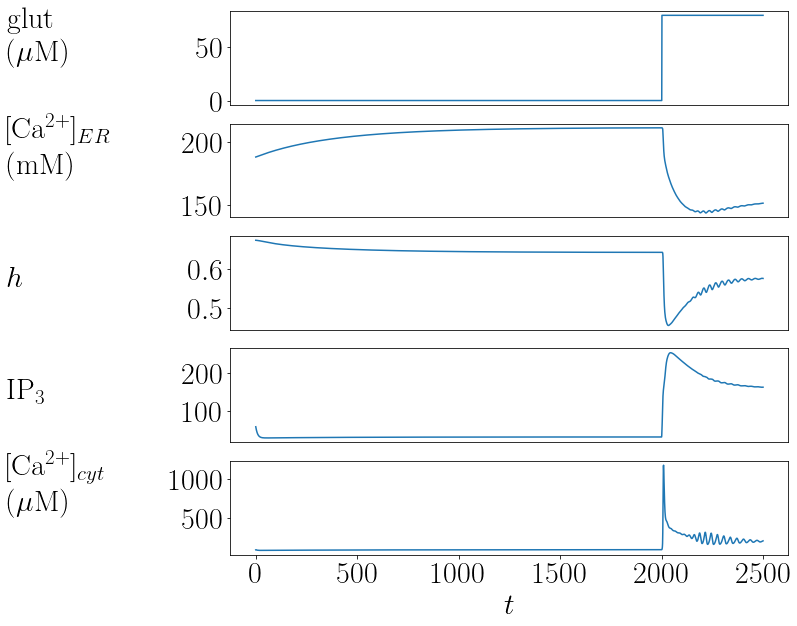

In [15]:
cfg.v_soc = 2.5
cfg.input_max = 0.08
cfg.input_start = 2000
cfg.input_duration = 500
input_start = 2000
run_experiment('pulse', t_f=2500, max_step=1)
plot_experiment_plots(['glut', 'c_er', 'h', 'p', 'c'])



cfg.v_soc = 1.57



In [ ]:
largest = np.argmax(

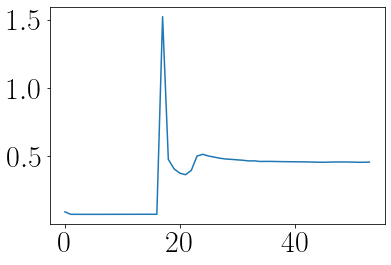

In [22]:
plt.plot(c_peaks)
plt.scatter(c_peaks[second_largest]

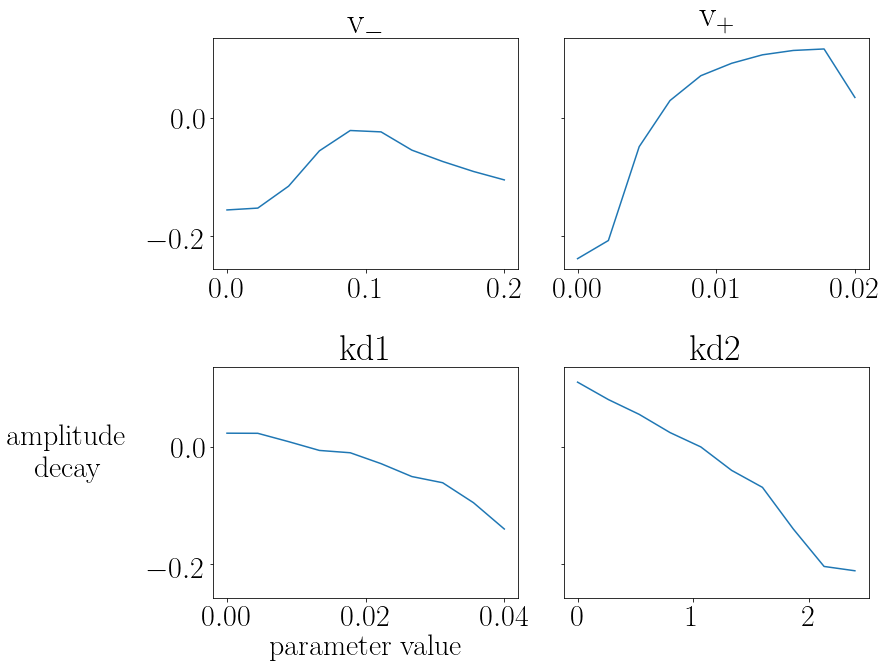

In [43]:
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    plot_x = []
    amp_changes = []
    isi_changes = []
    
    for j in range(len(rnge)):
        if len(all_c_peaks[var][j]) > 2:
            first_c_peak = all_c_peaks[var][j][1]
            last_c_peak = all_c_peaks[var][j][-1]
            amp_changes.append( last_c_peak - first_c_peak )

            first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
            last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
            isi_changes.append( last_isi - first_isi )
            
            plot_x.append(rnge[j])
    
    ax[x, y].plot(plot_x, amp_changes)
    ax[x, y].set_title(labels[i])
    
ax[1, 0].set_xlabel('parameter value')
ax[1, 0].set_ylabel('amplitude \n decay', rotation=0, labelpad=80)

plt.tight_layout()
        

In [36]:
decays['v_3k']

[-0.039356516546013465,
 -0.031542690618987845,
 -0.028169095739722816,
 -0.02503898237228397,
 -0.020986417623062303,
 -0.018725329848079397,
 -0.017288710017232867,
 -0.017315995524300742,
 -0.01591408756071966,
 -0.016687095955279285]

In [41]:
cfg.v_3k

0.1

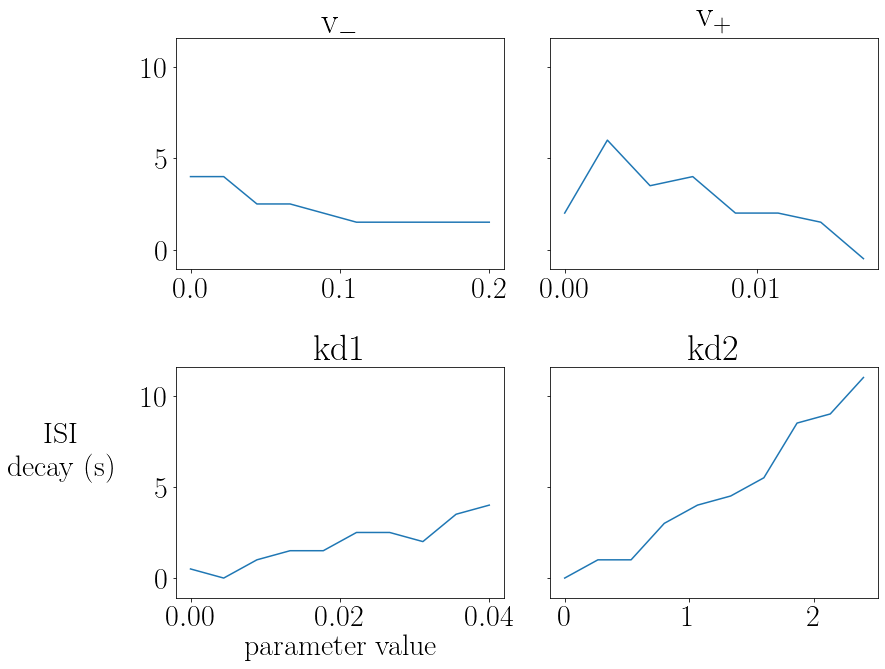

In [481]:
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    plot_x = []
    amp_changes = []
    isi_changes = []
    
    for j in range(len(rnge)):
        if len(all_c_peaks[var][j]) > 2:
            first_c_peak = all_c_peaks[var][j][1]
            last_c_peak = all_c_peaks[var][j][-1]
            amp_changes.append( last_c_peak - first_c_peak )

            first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
            last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
            isi_changes.append( last_isi - first_isi )
            
            plot_x.append(rnge[j])
    
    ax[x, y].plot(plot_x, isi_changes)
    ax[x, y].set_title(labels[i])
    
ax[1, 0].set_xlabel('parameter value')
ax[1, 0].set_ylabel('ISI \n decay (s)', rotation=0, labelpad=80)

plt.tight_layout()
        

**Same results with $v_+$ set to 0.005 (default 0.01)**

In [79]:
cfg.input_start = -10
cfg.input_max = 0.1

ranges = [np.linspace(0, 0.2, 10),
np.linspace(0, 0.02, 10),
np.linspace(0, 0.04, 10),
np.linspace(0, 2.4, 10)]
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
# default_vals = [0.1, 0.01, 0.02, 0.6]
default_vals = [0.1, 0.005, 0.02, 0.6]

# v3ks = np.linspace(0, 0.2, 10)
# vdeltas = np.linspace(0, 0.02, 10)
# kd1s = np.linspace(0, 0.04, 10)
# kd2s = np.linspace(0, 2.4, 10)

set_init('poisson')
# cfg.all_init = all_init3
# cfg.all_init = [0.11909532339511657,
#  23.28081394731322,
#  0.5885149421133017,
#  0.17761312473773083,
#  0.05217067363760168,
#  0.15905260305735866,
#  0.2744065020998043,
#  0.004039453889399858] #after 0.2 noise

all_t_peaks2 = {}
all_c_peaks2 = {}
for var in variables:
    all_t_peaks2[var] = []
    all_c_peaks2[var] = []


for j, var in enumerate(tqdm(variables)):
    for i, reset_var in enumerate(variables):
        setattr(cfg, reset_var, default_vals[i])
    rnge = ranges[j]
    
    for val in rnge:
        setattr(cfg, var, val)
        run_experiment('pulse', t_f=250, max_step=0.5)
        
        peaks = scipy.signal.find_peaks(cfg.c)[0]
        return_low_lim = 200 #how far does calcium have to return before we consider
                             #ourselves to be in standard oscillation range
        first_peak = peaks[0]
        return_low = np.argmax(cfg.c[first_peak:] < return_low_lim)
        if return_low == 0:
            osc_start = -1
        else:
            osc_start = first_peak + return_low
        peaks = np.append([first_peak], scipy.signal.find_peaks(cfg.c[osc_start:])[0] + osc_start)
        c_peaks = cfg.c[peaks]
        t_peaks = cfg.t[peaks]
        
        all_t_peaks2[var].append(t_peaks)
        all_c_peaks2[var].append(c_peaks)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


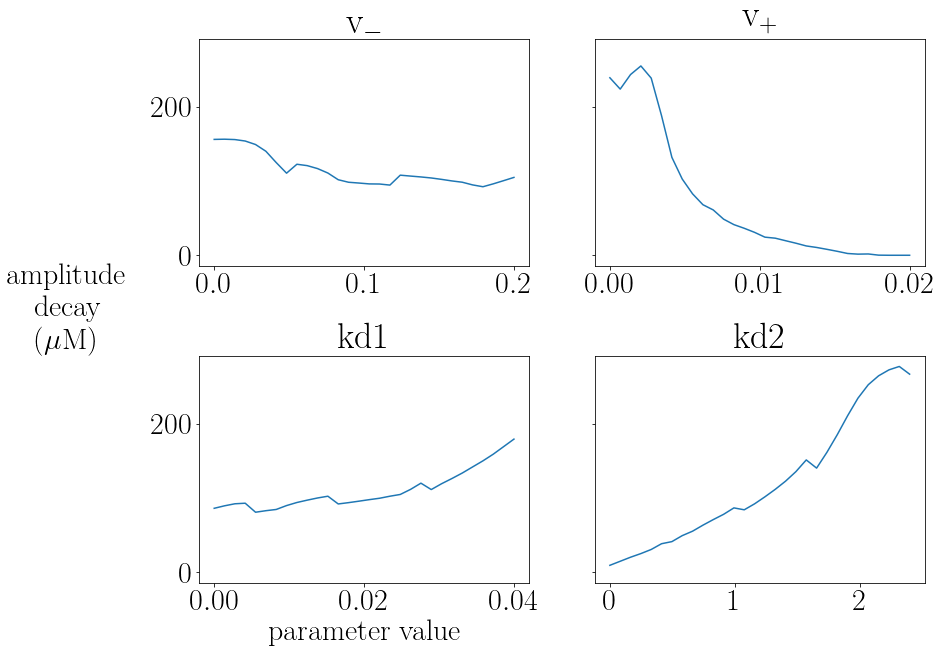

In [78]:
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
decays = pickle.load(open('data/plot_data/falloff/2.1_oscillation_var', 'rb'))
ranges = [np.linspace(0, 0.2, 30),
np.linspace(0, 0.02, 30),
np.linspace(0, 0.04, 30),
np.linspace(0, 2.4, 30)]

fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)

plt.subplots_adjust(hspace=0.4)

for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    plot_x = []
    
    ax[x, y].plot(rnge, -np.array(decays[var] )* 1000)
    ax[x, y].set_title(labels[i])
    
ax[1, 0].set_xlabel('parameter value')
ax[1, 0].set_ylabel('amplitude \n decay \n ($\mu$M)', rotation=0, labelpad=80)

# plt.tight_layout()
ax[1, 0].yaxis.set_label_coords(-0.4, 1)
plt.savefig('figures/paper_plots/falloff/2_1_var_falloffs', bbox_inches='tight')

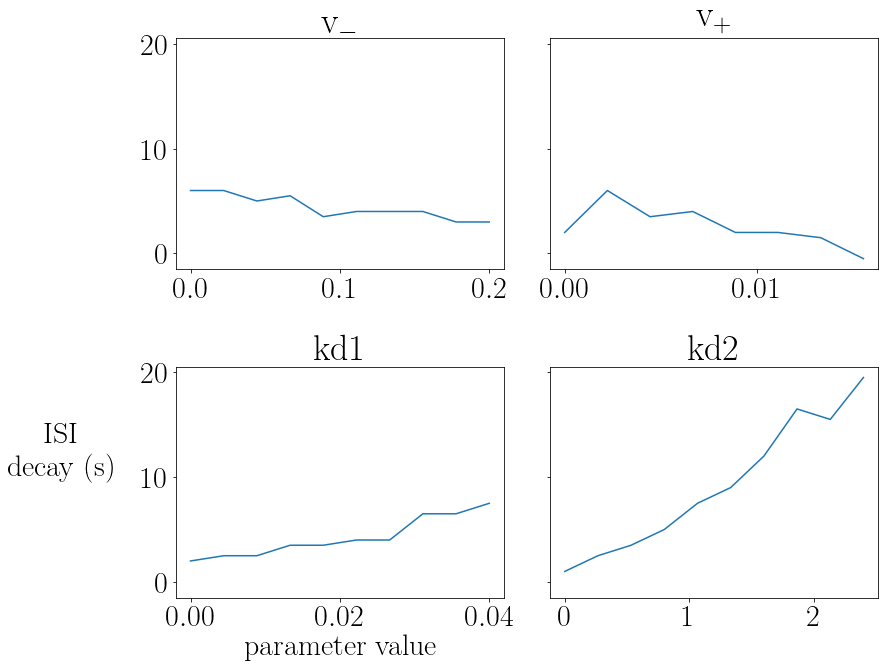

In [489]:
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    plot_x = []
    amp_changes = []
    isi_changes = []
    
    for j in range(len(rnge)):
        if len(all_c_peaks2[var][j]) > 2:
            first_c_peak = all_c_peaks2[var][j][1]
            last_c_peak = all_c_peaks2[var][j][-1]
            amp_changes.append( last_c_peak - first_c_peak )

            first_isi = all_t_peaks2[var][j][2] - all_t_peaks2[var][j][1]
            last_isi = all_t_peaks2[var][j][-1] - all_t_peaks2[var][j][-2]
            isi_changes.append( last_isi - first_isi )
            
            plot_x.append(rnge[j])
    
    ax[x, y].plot(plot_x, isi_changes)
    ax[x, y].set_title(labels[i])
    
ax[1, 0].set_xlabel('parameter value')
ax[1, 0].set_ylabel('ISI \n decay (s)', rotation=0, labelpad=80)

plt.tight_layout()

**Compare decay rates**

Here we compare the amplitude decay curves while changing $k_{d2}$ for when $v_+$ is 0.01 vs 0.005

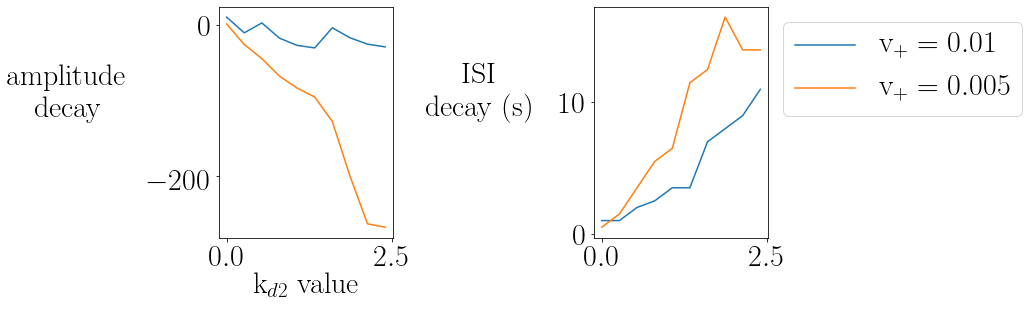

In [80]:
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
legend = ['v$_+ = 0.01$', 'v$_+ = 0.005$']
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

i = 3
var = labels[i]
rnge = ranges[i]

for k in range(2):
    amp_changes = []
    isi_changes = []
    plot_x = []

    if k == 0:
        c_peaks = all_c_peaks
        t_peaks = all_t_peaks
    else:
        c_peaks = all_c_peaks2
        t_peaks = all_t_peaks2
        
    for j in range(len(rnge)):
        if len(c_peaks[var][j]) > 2:
            first_c_peak = c_peaks[var][j][1]
            last_c_peak = c_peaks[var][j][-1]
            amp_changes.append( last_c_peak - first_c_peak )

            first_isi = t_peaks[var][j][2] - t_peaks[var][j][1]
            last_isi = t_peaks[var][j][-1] - t_peaks[var][j][-2]
            isi_changes.append( last_isi - first_isi )

            plot_x.append(rnge[j])

    ax[0].plot(plot_x, amp_changes)
    ax[1].plot(plot_x, isi_changes, label=legend[k])

ax[0].set_xlabel('k$_{d2}$ value')
ax[0].set_ylabel('amplitude \n decay', rotation=0, labelpad=80)
ax[1].set_ylabel('ISI \n decay (s)', rotation=0, labelpad=80)

ax[1].legend(bbox_to_anchor=(1, 1, 0, 0))
plt.tight_layout()
        

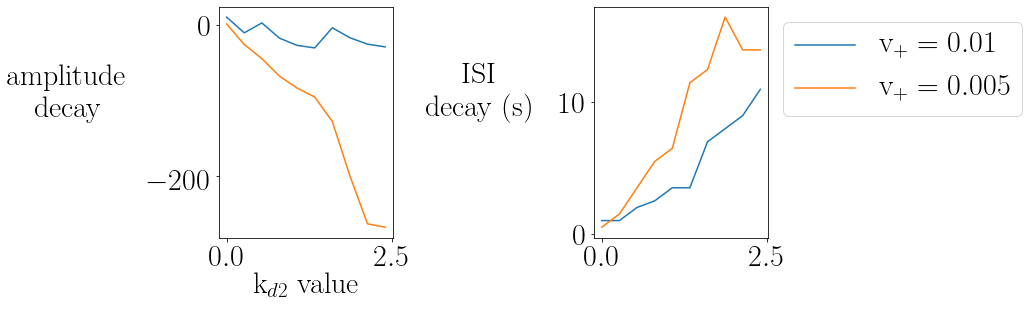

In [80]:
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
legend = ['v$_+ = 0.01$', 'v$_+ = 0.005$']
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

i = 3
var = labels[i]
rnge = ranges[i]

for k in range(2):
    amp_changes = []
    isi_changes = []
    plot_x = []

    if k == 0:
        c_peaks = all_c_peaks
        t_peaks = all_t_peaks
    else:
        c_peaks = all_c_peaks2
        t_peaks = all_t_peaks2
        
    for j in range(len(rnge)):
        if len(c_peaks[var][j]) > 2:
            first_c_peak = c_peaks[var][j][1]
            last_c_peak = c_peaks[var][j][-1]
            amp_changes.append( last_c_peak - first_c_peak )

            first_isi = t_peaks[var][j][2] - t_peaks[var][j][1]
            last_isi = t_peaks[var][j][-1] - t_peaks[var][j][-2]
            isi_changes.append( last_isi - first_isi )

            plot_x.append(rnge[j])

    ax[0].plot(plot_x, amp_changes)
    ax[1].plot(plot_x, isi_changes, label=legend[k])

ax[0].set_xlabel('k$_{d2}$ value')
ax[0].set_ylabel('amplitude \n decay', rotation=0, labelpad=80)
ax[1].set_ylabel('ISI \n decay (s)', rotation=0, labelpad=80)

ax[1].legend(bbox_to_anchor=(1, 1, 0, 0))
plt.tight_layout()
        

### Mean changes comparing ER storage emptying rates

Note that there are special ways that we are performing these experiments in order to produce cleaner results
* We perform the bath stimulation at 100$\mu$M for 10 minutes
* To compute amplitude change, we compare the maximum peak (disregarding the first initial spike) to the second from last peak (the last peak is subject to arbitrary cut off to the 10 minute stimulation)
* In order to perform the "ER depletion" experiment we take the ER calcium generated from a control bath experiment and scale it. Because of this, we are not simulating the dynamics of ER, leading to mismatched timings of ER and cytosolic calcium spikes. To prevent this, we instead feed in a smoothed version of the ER calcium curve to the model

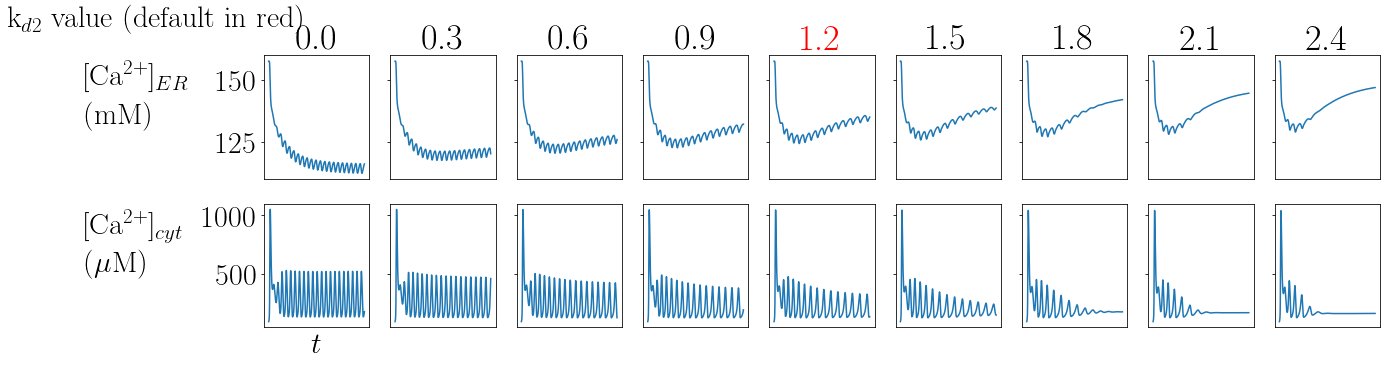

In [80]:
cfg.input_start = -10
cfg.input_max = 0.1
cfg.input_duration = 1000
cfg.v_delta = 0.005

set_init('poisson')
# run_experiment('pulse', t_f=250, max_step=0.5)
# fix_c_er = cfg.c_er

fig, ax = plt.subplots(2, 9, figsize=(20, 5), sharey='row', sharex=True)

for i, mult in enumerate(np.linspace(0, 2.4, 9)):
    # print(mult)
    # inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    cfg.kd2 = mult
    run_experiment('pulse', t_f=500, max_step=0.5)
    plot_experiment_plots(['c_er', 'c'], axs=ax[:, i], add_ylabels=(i == 0), add_xlabel=(i==0), ylabel_padding=[-1.7, 0.4],
                         plot_input=False)
    c = 'red' if mult == 1.2 else 'black'
    ax[0, i].set_title(mult, color=c)

    ax[0, i].set_title(round(mult, 3))

plt.text(0.05, 0.95, 'k$_{d2}$ value (default in red)', transform=plt.gcf().transFigure, ha='center', fontsize=30)
# plot_experiment_plots(['glut', 'c_er', 'c'])
cfg.kd2 = 0.6

plt.savefig(save + '2_2_1_kd2_examples.png', bbox_inches='tight')



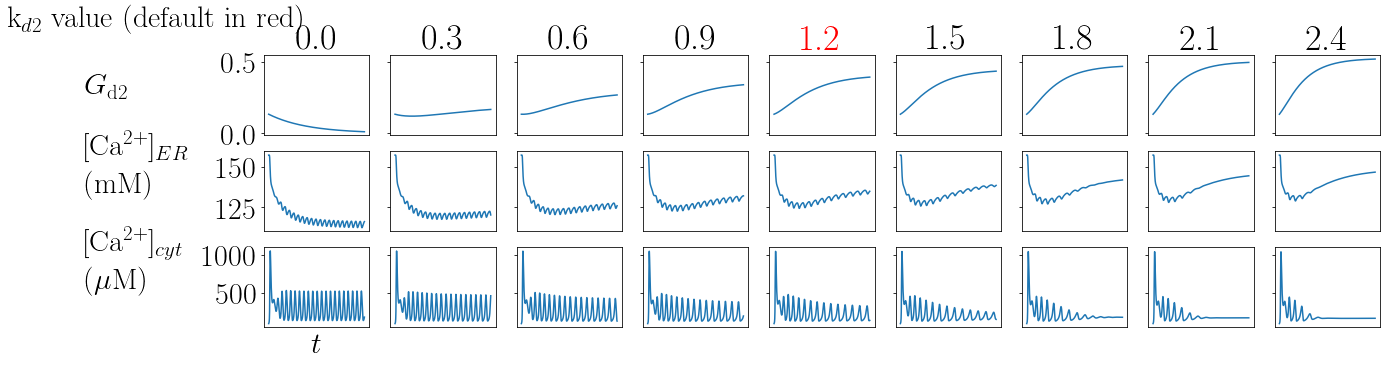

In [82]:
cfg.input_start = -10
cfg.input_max = 0.1
cfg.input_duration = 1000
cfg.v_delta = 0.005

set_init('poisson')
# run_experiment('pulse', t_f=250, max_step=0.5)
# fix_c_er = cfg.c_er

fig, ax = plt.subplots(3, 9, figsize=(20, 5), sharey='row', sharex=True)

for i, mult in enumerate(np.linspace(0, 2.4, 9)):
    # print(mult)
    # inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    cfg.kd2 = mult
    run_experiment('pulse', t_f=500, max_step=0.5)
    plot_experiment_plots(['Gd2', 'c_er', 'c'], axs=ax[:, i], add_ylabels=(i == 0), add_xlabel=(i==0), ylabel_padding=[-1.7, 0.4],
                         plot_input=False)
    c = 'red' if mult == 1.2 else 'black'
    ax[0, i].set_title(mult, color=c)

    ax[0, i].set_title(round(mult, 3))

plt.text(0.05, 0.95, 'k$_{d2}$ value (default in red)', transform=plt.gcf().transFigure, ha='center', fontsize=30)
# plot_experiment_plots(['glut', 'c_er', 'c'])
cfg.kd2 = 0.6

# plt.savefig(save + '2_2_1_kd2_examples.png', bbox_inches='tight')



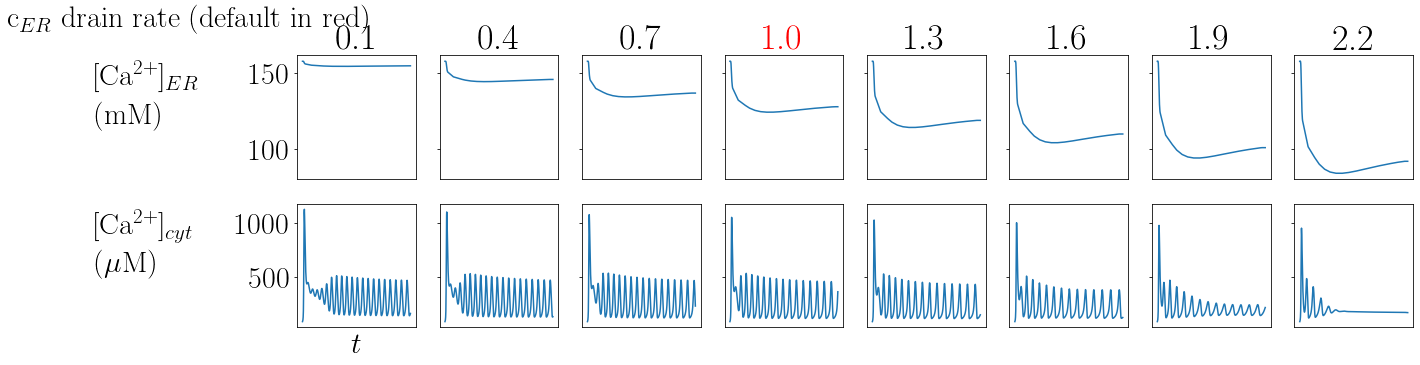

In [81]:
cfg.input_start = -10
cfg.input_max = 0.1
cfg.input_duration = 1200
cfg.v_delta = 0.005
cfg.kd2 = 0.6
set_init('poisson')
run_experiment('pulse', t_f=500, max_step=0.5)
fix_c_er = cfg.c_er

fig, ax = plt.subplots(2, 8, figsize=(20, 5), sharey='row', sharex=True)

peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)
for i, mult in enumerate([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2]):
    # print(mult)
    inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er_func=inter)
    plot_experiment_plots(['c_er', 'c'], axs=ax[:, i], add_ylabels=(i == 0), add_xlabel=(i==0), ylabel_padding=[-1.7, 0.4],
                         plot_input=False)
    c = 'red' if mult == 1.0 else 'black'
    ax[0, i].set_title(mult, color=c)

plt.text(0.05, 0.95, 'c$_{ER}$ drain rate (default in red)', transform=plt.gcf().transFigure, ha='center', fontsize=30)
# plot_experiment_plots(['glut', 'c_er', 'c'])

plt.savefig(save + '2_2_1_c_er_examples.png', bbox_inches='tight')

In [ ]:
decay

In [84]:
cfg.input_start = -10
cfg.input_max = 0.1

default_vals = [0.1, 0.005, 0.02, 0.6]
kd2s = np.linspace(0, 2.4, 10)
multipliers = np.linspace(0, 2, 100)
cfg.v_3k = 0.1
cfg.v_delta = 0.005
cfg.kd1 = 0.02
cfg.kd2 = 1.2
set_init('poisson')

run_experiment('pulse', t_f=500, max_step=0.5)
peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)



def get_peaks(t, c):
    '''
    Get peaks for an oscillation
    '''
    # peaks = scipy.signal.find_peaks(c)[0]
    # return_low_lim = 200 #how far does calcium have to return before we consider
    #                      #ourselves to be in standard oscillation range
    # first_peak = peaks[0]
    # return_low = np.argmax(c[first_peak:] < return_low_lim)
    # if return_low == 0:
    #     osc_start = -1
    # else:
    #     osc_start = first_peak + return_low
    # peaks = np.append([first_peak], scipy.signal.find_peaks(c[osc_start:])[0] + osc_start)
    # c_peaks = c[peaks]
    # t_peaks = t[peaks]
    
    
    peaks = scipy.signal.find_peaks(cfg.c)[0]
    c_peaks = cfg.c[peaks]
    max_idx = np.argmax(c_peaks)
    peaks = peaks[max_idx:]
    second_largest = np.argmax(cfg.c[peaks[1:]]) + 1
    second_largest_c = cfg.c[peaks[second_largest]]
    second_largest_t = cfg.t[peaks[second_largest]]

    c_peaks = cfg.c[peaks]
    t_peaks = cfg.t[peaks]
    decay = c_peaks[-1] - second_largest_c
    return t_peaks, c_peaks, decay

    
variables = ['er_depletion', 'kd2']
    
all_t_peaks = {}
all_c_peaks = {}
decays = {}
for var in variables:
    all_t_peaks[var] = []
    all_c_peaks[var] = []
    decays[var] = []

var = 'er_depletion'
for mult in tqdm(multipliers):
    inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er_func=inter)
    t_peaks, c_peaks, decay = get_peaks(cfg.t, cfg.c)

    all_t_peaks[var].append(t_peaks)
    all_c_peaks[var].append(c_peaks)
    decays[var].append(decay)
    
var = 'kd2'
for mult in tqdm(multipliers):
    cfg.kd2 = 1.2 * mult
    run_experiment('pulse', t_f=500, max_step=0.5)
    t_peaks, c_peaks, decay = get_peaks(cfg.t, cfg.c)
    
    all_t_peaks[var].append(t_peaks)
    all_c_peaks[var].append(c_peaks)
    decays[var].append(decay)
        
save_data = [all_t_peaks, all_c_peaks, multipliers, decays]
pickle.dump(save_data, open('data/plot_data/oscillation_falloff_er_kd2', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s]


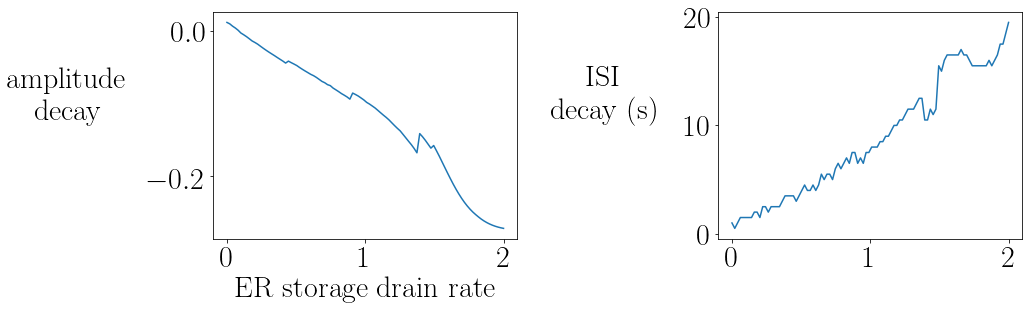

In [35]:
amp_changes = []
isi_changes = []
plot_x = []
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 2:
        first_c_peak = all_c_peaks[var][j][1]
        last_c_peak = all_c_peaks[var][j][-1]
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])

# ax[x, y].plot(plot_x, isi_changes)
# ax[x, y].set_title(labels[i])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(plot_x, amp_changes)
ax[0].set_ylabel('amplitude \n decay', rotation=0, labelpad=80)
ax[1].plot(plot_x, isi_changes)
ax[1].set_ylabel('ISI \n decay (s)', rotation=0, labelpad=80)
ax[0].set_xlabel('ER storage drain rate')
plt.tight_layout()


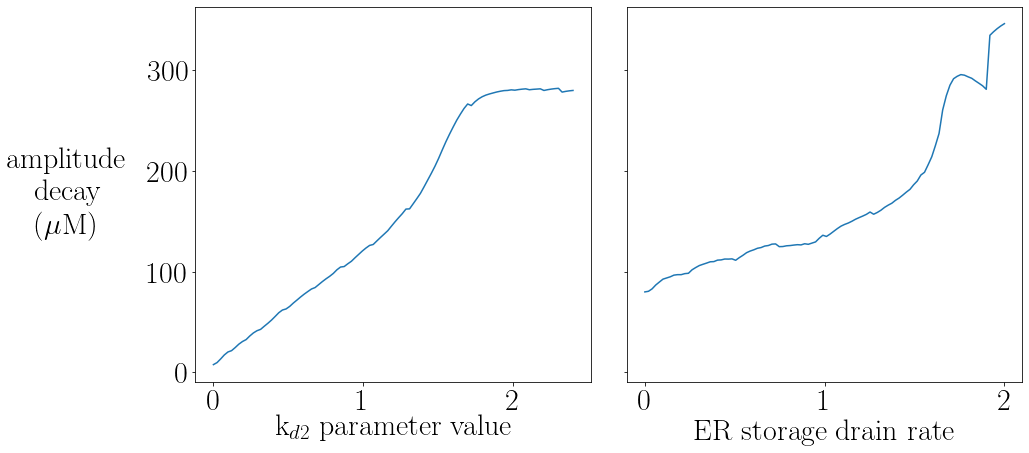

In [177]:
all_t_peaks, all_c_peaks, multipliers = \
    pickle.load(open('data/plot_data/oscillation_falloff_er_kd2', 'rb'))

amp_changes = []
isi_changes = []
plot_x = []
var = 'kd2'
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])

# ax[x, y].plot(plot_x, isi_changes)
# ax[x, y].set_title(labels[i])

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
ax[0].plot(np.array(plot_x) * 1.2, -np.array(amp_changes))
ax[0].set_ylabel('amplitude \n decay \n ($\mu$M)', rotation=0, labelpad=80, va='center')
ax[0].set_xlabel('k$_{d2}$ parameter value')

amp_changes = []
isi_changes = []
plot_x = []
var = 'er_depletion'
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])
        
ax[1].plot(plot_x, -np.array(amp_changes))
ax[1].set_xlabel('ER storage drain rate')


plt.tight_layout()
plt.savefig('figures/paper_plots/falloff/2_2_1_kd2_er_oscillation_amplitude.png', bbox_inches='tight')


In [92]:
d = pickle.load(open('data/plot_data/oscillation_falloff_er_kd2', 'rb'))

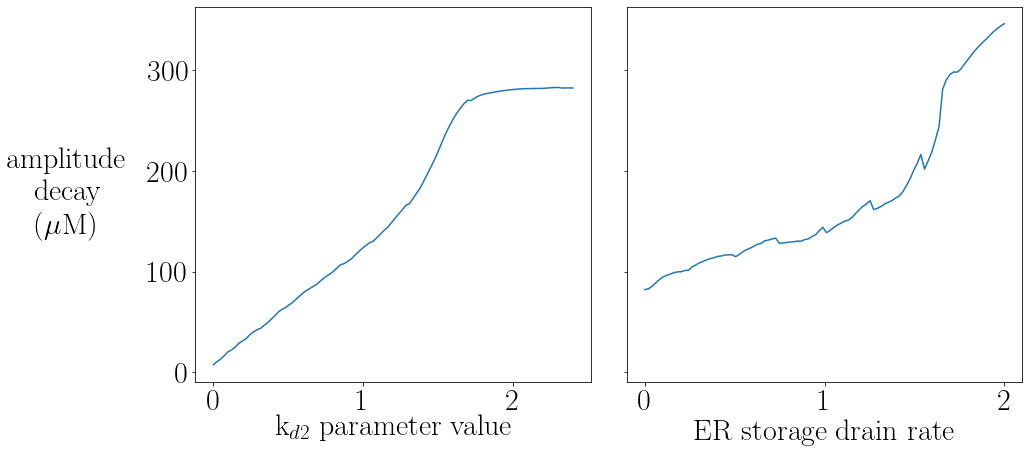

In [94]:
all_t_peaks, all_c_peaks, multipliers, decays = \
    pickle.load(open('data/plot_data/oscillation_falloff_er_kd2', 'rb'))

amp_changes = []
isi_changes = []
plot_x = []
var = 'kd2'
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])

# ax[x, y].plot(plot_x, isi_changes)
# ax[x, y].set_title(labels[i])

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
# ax[0].plot(np.array(plot_x) * 1.2, -np.array(amp_changes))
ax[0].plot(np.array(plot_x) * 1.2, -np.array(decays[var]) * 1000)
ax[0].set_ylabel('amplitude \n decay \n ($\mu$M)', rotation=0, labelpad=80, va='center')
ax[0].set_xlabel('k$_{d2}$ parameter value')

amp_changes = []
isi_changes = []
plot_x = []
var = 'er_depletion'
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])
        
# ax[1].plot(plot_x, -np.array(amp_changes))
ax[1].plot(plot_x, -np.array(decays[var]) * 1000)
ax[1].set_xlabel('ER storage drain rate')


plt.tight_layout()
plt.savefig('figures/paper_plots/falloff/2_2_1_kd2_er_oscillation_amplitude.png', bbox_inches='tight')


In [92]:
amp_changes

[-79.82491486982423,
 -80.44291759287393,
 -82.86442388634839,
 -86.6680666695816,
 -89.61960132879443,
 -92.49523914475088,
 -93.65190451845564,
 -94.80973909827338,
 -96.45074179213003,
 -96.92242243539482,
 -96.92068465736031,
 -97.94383735113604,
 -98.29174680911035,
 -101.7433072152374,
 -103.96666852663418,
 -105.95621317592219,
 -107.20095842008601,
 -108.39701374034127,
 -109.67760228519825,
 -109.86694379255908,
 -111.32114850859682,
 -111.55252640643198,
 -112.41791317969506,
 -112.35280741493449,
 -112.57923874252236,
 -111.17218492756581,
 -113.80146871344249,
 -116.09452304178058,
 -118.68785587263687,
 -120.32194808160841,
 -121.55747535786372,
 -123.07628506996076,
 -123.78379289698415,
 -125.26561966439635,
 -125.79696622281546,
 -127.18180680125579,
 -127.38766222915666,
 -124.68386552923926,
 -124.80234876889494,
 -125.52240559146702,
 -125.76209036750441,
 -126.24187925781712,
 -126.63039439892259,
 -126.41019361813511,
 -127.56221061522501,
 -127.0081109810493,
 -12

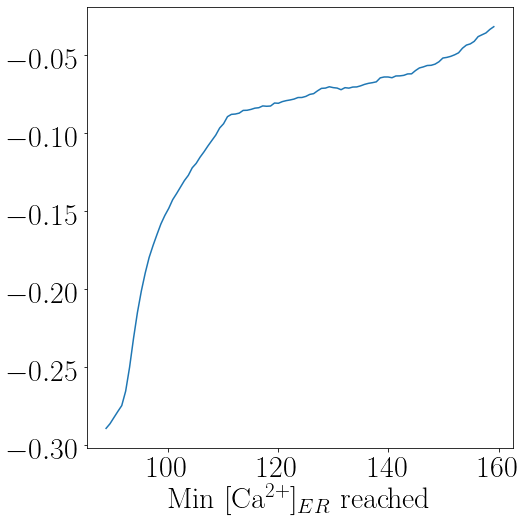

In [97]:
amp_changes = []
isi_changes = []
plot_x = []
var = 'er_depletion'

cfg.input_start = -10
cfg.input_max = 0.1
cfg.input_duration = 1200
cfg.v_delta = 0.005
cfg.kd2 = 0.6
set_init('poisson')
run_experiment('pulse', t_f=500, max_step=0.5)
peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)
t = np.linspace(0, 600, 3000)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        mult = multipliers[j]
        inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
        min_c_er = np.min(inter(t))

        
        # plot_x.append(multipliers2[j])
        plot_x.append(min_c_er)
ax.plot(plot_x, amp_changes)
# ax.set_xlabel('ER storage drain rate')
ax.set_xlabel('Min [Ca$^{2+}$]$_{ER}$ reached')


plt.tight_layout()


### Turning off/on kd2/ER drain

In [105]:
def run_conditional(conds=['kd2_off', 'drain_off']):
    '''
    conds: select options to run experiment with
    '''
    cfg.kd1 = 0.02
    cfg.v_delta = 0.005
    cfg.v_3k = 0.1
    # cfg.input_max = 0.08
    set_init('poisson')
    if 'kd2_off' in conds:
        cfg.kd2 = 0
    else:
        cfg.kd2 = 1.2
        # cfg.kd2 = 0.6
    # print(cfg.kd2)
        
    fix_c_er_val = 159.142628
    if 'drain_off' in conds:
        run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er=fix_c_er_val)
    else:
        run_experiment('pulse', t_f=500, max_step=0.5)
        
        
def get_peaks(t, c):
    '''
    Get peaks for an oscillation
    '''
    peaks = scipy.signal.find_peaks(c)[0]
    return_low_lim = 250 #how far does calcium have to return before we consider
                         #ourselves to be in standard oscillation range
    first_peak = peaks[0]
    return_low = np.argmax(c[first_peak:] < return_low_lim)
    if return_low == 0:
        osc_start = -1
    else:
        osc_start = first_peak + return_low
    peaks = np.append([first_peak], scipy.signal.find_peaks(c[osc_start:])[0] + osc_start)
    c_peaks = c[peaks]
    t_peaks = t[peaks]
    return t_peaks, c_peaks



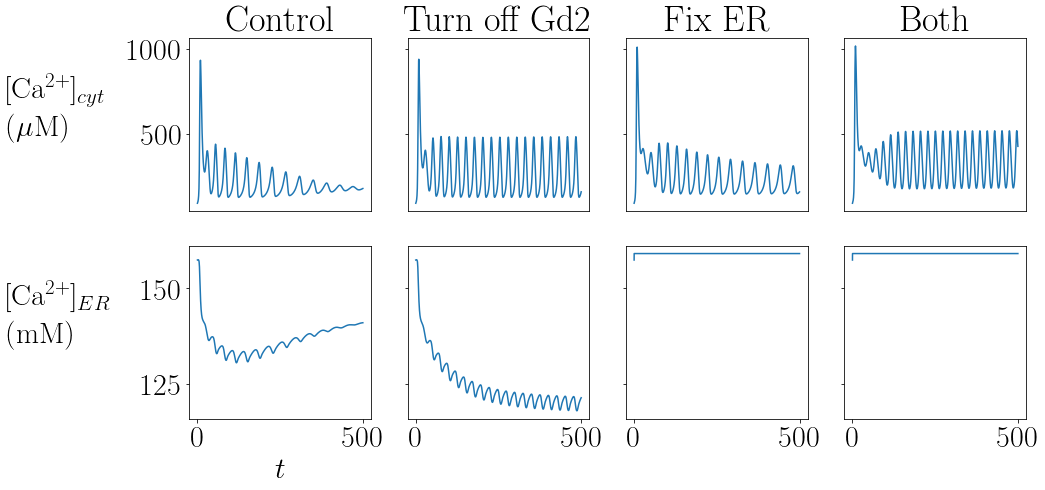

In [120]:


condss = [['control'], ['kd2_off'], ['drain_off'], ['kd2_off', 'drain_off']]
labels = ['Control', 'Turn off Gd2', 'Fix ER', 'Both']
fig, ax = plt.subplots(2, 4, figsize=(15, 7), sharey='row')
cfg.input_max = 0.08
for i, conds in enumerate(condss):
    run_conditional(conds)
    plot_experiment_plots(['c', 'c_er'], axs=ax[:, i], legend_label=labels[i], ylabel_padding=[-1, 0.4],
                     add_ylabels=(i == 0), add_xlabel=(i==0), plot_input=False)
    ax[0, i].set_title(labels[i])

plt.savefig(save + '2.2.2_condition_examples.png', bbox_inches='tight')

In [106]:
gluts = np.linspace(0.03, 0.25, 30)
condss = [['control'], ['kd2_off'], ['drain_off'], ['kd2_off', 'drain_off']]
labels = ['Control', 'Turn off Gd2', 'Fix ER', 'Both']

cfg.input_duration = 2000
cfg.input_start = -10
# set_init('poisson')
cfg.all_init = [0.0951442, 26.370394600930247, 0.6167209424320252, 0.1442844225467311, 0, 0, 0, 0]

all_t_peaks = {}
all_c_peaks = {}
for label in labels:
    all_t_peaks[label] = []
    all_c_peaks[label] = []

for i, conds in enumerate(tqdm(condss)):
    label = labels[i]
    for glut in gluts:
        cfg.input_max = glut
        run_conditional(conds=conds)
        
        t_peaks, c_peaks = get_peaks(cfg.t, cfg.c)

        all_t_peaks[label].append(t_peaks)
        all_c_peaks[label].append(c_peaks)

save_data = [all_t_peaks, all_c_peaks, gluts]
pickle.dump(save_data, open('data/plot_data/oscillation_falloff_conditions', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.71s/it]


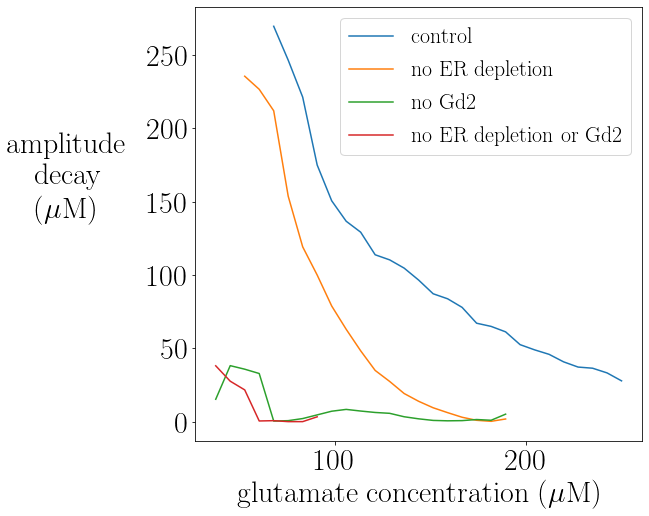

In [95]:
plt.figure(figsize=(8, 8))
all_t_peaks, all_c_peaks, gluts = pickle.load(open('data/plot_data/oscillation_falloff_conditions', 'rb'))

labels = ['Control', 'Fix ER', 'Turn off Gd2', 'Both']
legend_labels = ['control', 'no ER depletion', 'no Gd2', 'no ER depletion or Gd2']
idx_starts = [7, 4, 1, 1]
for i, label in enumerate(labels):
    plot_x = []
    amp_changes = []
    for j, glut in enumerate(gluts):
        if len(all_c_peaks[label][j]) > idx_starts[i]:
            first_c_peak = np.max(all_c_peaks[label][j][1:])
            last_c_peaks = all_c_peaks[label][j][-2]
            last_c_peak = np.mean(last_c_peaks)

            amp_changes.append( last_c_peak - first_c_peak )
            plot_x.append(glut)
    
    plt.plot(np.array(plot_x) * 1000, -np.array(amp_changes), label=legend_labels[i])
    
plt.legend(fontsize=22)
plt.ylabel('amplitude \n decay \n ($\mu$M)', rotation=0, labelpad=80)
plt.xlabel('glutamate concentration ($\mu$M)')
    
plt.savefig(save + '2_2_2_condition_results.png', bbox_inches='tight')

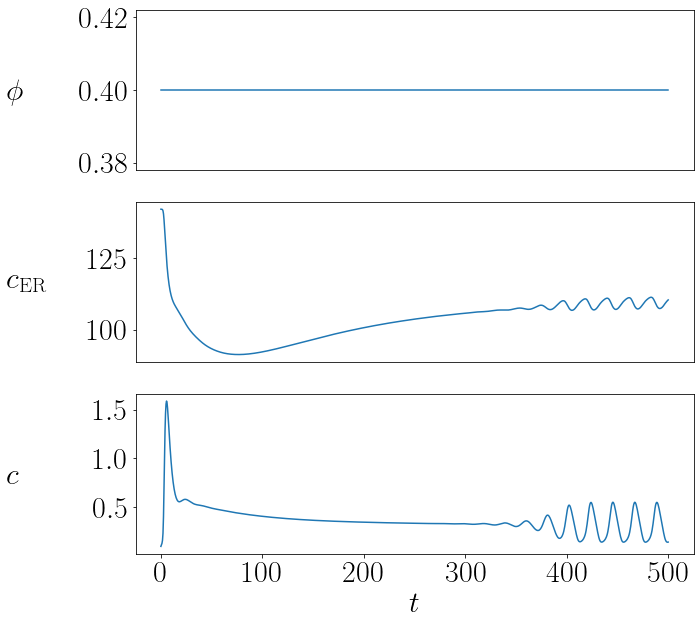

In [93]:
cfg.input_max = 0.4
run_conditional([])
plot_experiment_plots(['glut', 'c_er', 'c'])

## Step Experiments

After seeing successful recreation of some oscillation amplitude falloffs, can run some more step experiments too

In [21]:
cfg.v_delta

0.005

In [ ]:
glut = np.l

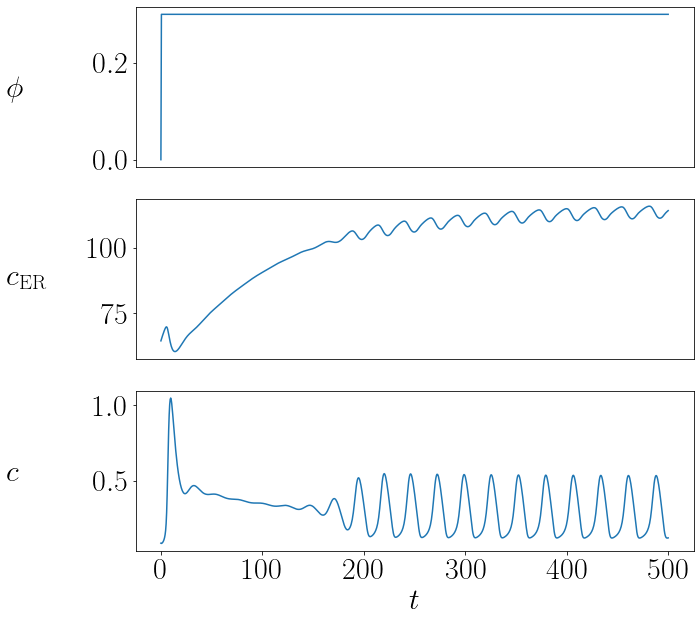

In [33]:
cfg.input_max = 0.3
cfg.input_duration = 600
cfg.input_start = 0
cfg.kr2 = 0.005
cfg.kd2 = 1.2
cfg.v_3k = 0
cfg.v_delta = 0.005
cfg.all_init
set_init('poisson')
cfg.all_init[1] = 12
run_experiment('pulse', t_f=500, max_step=0.5)
# plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'lamb', 'c_er', 'h', 'p', 'c'])
plot_experiment_plots(['glut', 'c_er', 'c'])

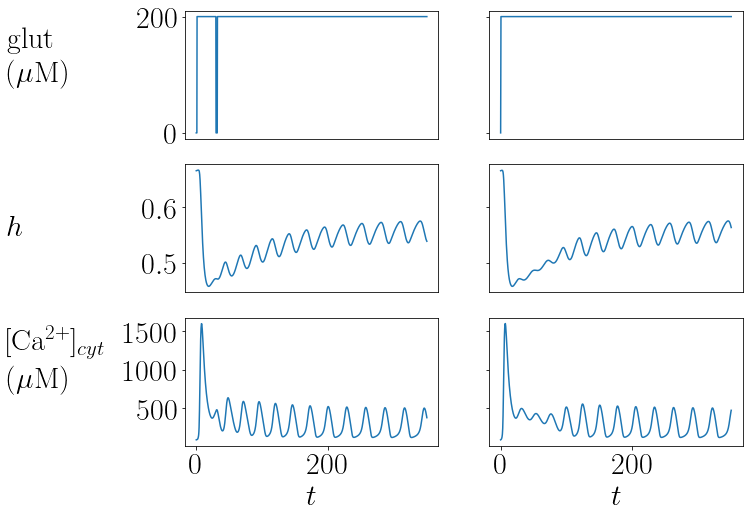

In [171]:
cfg.input_max = 0.2
cfg.input_duration = 600
cfg.input_start = 0
cfg.kr2 = 0.005
cfg.kd2 = 1.2
cfg.v_3k = 0
cfg.v_delta = 0.005
set_init('poisson')
fig, ax = plt.subplots(3, 2, figsize=(10, 8), sharey='row')
cfg.custom_input_times = [0, 1, 30, 32]
cfg.custom_input_vals = [0, 0.2, 0, 0.2]
run_experiment('custom', t_f=350, max_step=0.3)
plot_experiment_plots(['glut', 'h', 'c'], axs=ax[:, 0], ylabel_padding=[-0.7, 0.4])

run_experiment('pulse', t_f=350, max_step=0.5)
plot_experiment_plots(['glut', 'h', 'c'], axs=ax[:, 1], add_ylabels=False)
# plt.plot(cfg.t, cfg.c)

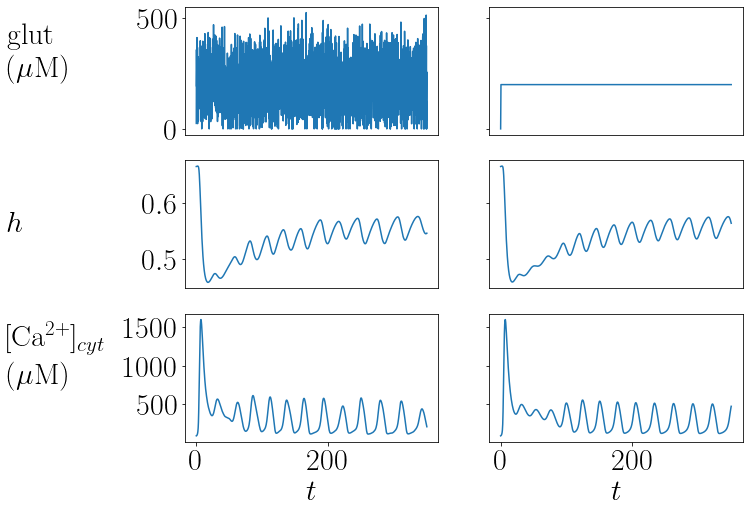

In [176]:
cfg.input_max = 0.2
cfg.input_duration = 600
cfg.input_start = 0
cfg.kr2 = 0.005
cfg.kd2 = 1.2
cfg.v_3k = 0
cfg.v_delta = 0.005
set_init('poisson')
fig, ax = plt.subplots(3, 2, figsize=(10, 8), sharey='row')
cfg.custom_input_times = [0, 1, 30, 32]
cfg.custom_input_vals = [0, 0.2, 0, 0.2]
run_experiment('pulse', t_f=350, max_step=0.5, noise=0.1)
plot_experiment_plots(['glut', 'h', 'c'], axs=ax[:, 0], ylabel_padding=[-0.7, 0.4])

run_experiment('pulse', t_f=350, max_step=0.5)
plot_experiment_plots(['glut', 'h', 'c'], axs=ax[:, 1], add_ylabels=False)
# plt.plot(cfg.t, cfg.c)

-0.13474392785712297


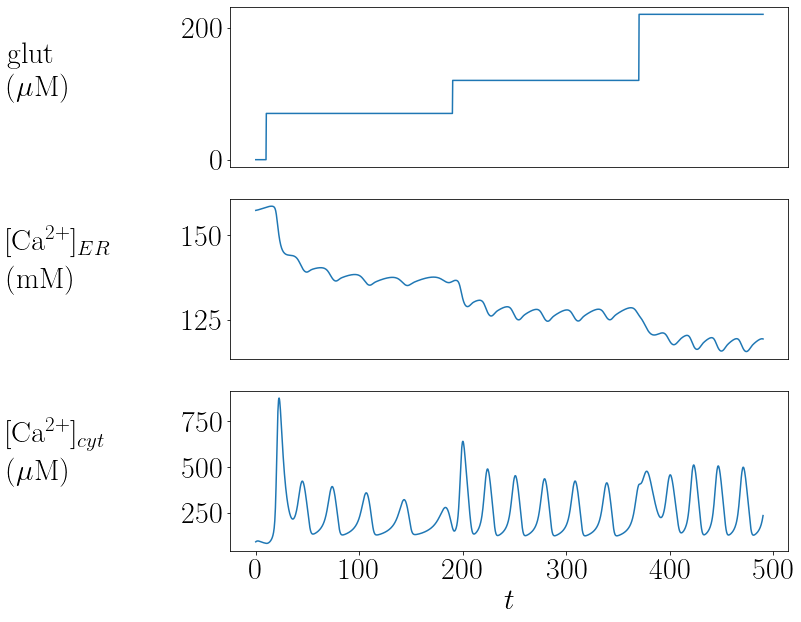

In [100]:
cfg.input_max = 0.07
cfg.custom_input_times = [0, 10, 190, 370]
cfg.custom_input_vals = [0, 0.07, 0.12, 0.22]
cfg.kd2 = 1.2
set_init('poisson')
# run_conditional(['kd2_off', 'drain_off'])
# run_conditional([])
run_experiment('custom', t_f=490, max_step=0.3)
plot_experiment_plots(['glut', 'c_er', 'c'])

t_peaks, c_peaks, decay = get_peaks(cfg.t, cfg.c)

if len(c_peaks) > 4:
    first_c_peak = np.max(c_peaks[1:])
    last_c_peaks = c_peaks[-2]
    last_c_peak = np.mean(last_c_peaks)

    print(last_c_peak - first_c_peak)
    
# print(amp_changes)
plt.savefig(save + '2_3_step_example.png', bbox_inches='tight')

[0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]

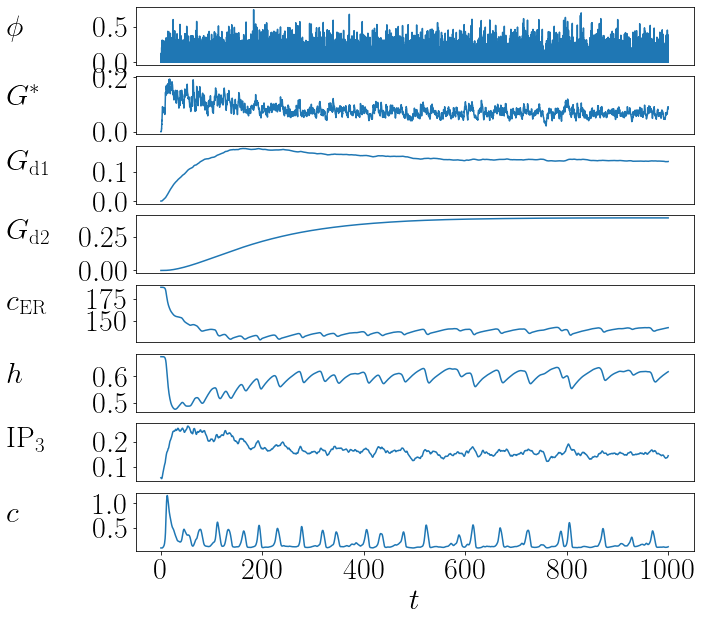

In [18]:
cfg.input_max = 0
cfg.input_duration = 300
run_experiment('pulse', noise=0.2, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c_er', 'h', 'p', 'c'])

cfg.all_init

In [178]:
gluts = np.linspace(1, 10, 10)
periods = np.linspace(4, 10, 10)

In [204]:
x, y = np.meshgrid(periods, gluts)

In [201]:
periods

array([ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
        7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ])

In [205]:
x

array([[ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ],
       [ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ],
       [ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ],
       [ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ],
       [ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ],
       [ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ],
       [ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667

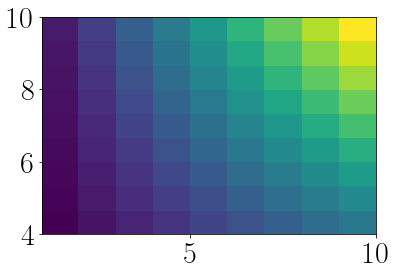

In [183]:
plt.pcolor(x, y, x*y)

In [184]:
ar = []
for glut in gluts:
    for period in periods:
        ar.append(glut * 2 + period)

In [196]:
x

array([[ 4.        ,  4.66666667,  5.33333333,  6.        ,  6.66666667,
         7.33333333,  8.        ,  8.66666667,  9.33333333, 10.        ]])

In [189]:
np.array(ar)

array([ 6.        ,  6.66666667,  7.33333333,  8.        ,  8.66666667,
        9.33333333, 10.        , 10.66666667, 11.33333333, 12.        ,
        8.        ,  8.66666667,  9.33333333, 10.        , 10.66666667,
       11.33333333, 12.        , 12.66666667, 13.33333333, 14.        ,
       10.        , 10.66666667, 11.33333333, 12.        , 12.66666667,
       13.33333333, 14.        , 14.66666667, 15.33333333, 16.        ,
       12.        , 12.66666667, 13.33333333, 14.        , 14.66666667,
       15.33333333, 16.        , 16.66666667, 17.33333333, 18.        ,
       14.        , 14.66666667, 15.33333333, 16.        , 16.66666667,
       17.33333333, 18.        , 18.66666667, 19.33333333, 20.        ,
       16.        , 16.66666667, 17.33333333, 18.        , 18.66666667,
       19.33333333, 20.        , 20.66666667, 21.33333333, 22.        ,
       18.        , 18.66666667, 19.33333333, 20.        , 20.66666667,
       21.33333333, 22.        , 22.66666667, 23.33333333, 24.  

In [187]:
np.array(ar).reshape(len(gluts), len(periods))

array([[ 6.        ,  6.66666667,  7.33333333,  8.        ,  8.66666667,
         9.33333333, 10.        , 10.66666667, 11.33333333, 12.        ],
       [ 8.        ,  8.66666667,  9.33333333, 10.        , 10.66666667,
        11.33333333, 12.        , 12.66666667, 13.33333333, 14.        ],
       [10.        , 10.66666667, 11.33333333, 12.        , 12.66666667,
        13.33333333, 14.        , 14.66666667, 15.33333333, 16.        ],
       [12.        , 12.66666667, 13.33333333, 14.        , 14.66666667,
        15.33333333, 16.        , 16.66666667, 17.33333333, 18.        ],
       [14.        , 14.66666667, 15.33333333, 16.        , 16.66666667,
        17.33333333, 18.        , 18.66666667, 19.33333333, 20.        ],
       [16.        , 16.66666667, 17.33333333, 18.        , 18.66666667,
        19.33333333, 20.        , 20.66666667, 21.33333333, 22.        ],
       [18.        , 18.66666667, 19.33333333, 20.        , 20.66666667,
        21.33333333, 22.        , 22.66666667